***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade xgboost > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "09"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time
import yaml

import category_encoders as ce
import xgboost as xgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster
import optuna

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [6]:
if ASSESS:
    dataset = (
        pd.read_parquet(f"{input_path}/train-m2.parquet")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    
dataset["nrows"] = dataset.groupby("sku")["ds"].transform("count")
print(dataset.sku.nunique())
print(dataset.query("nrows == 30").sku.nunique())

531832
500404


In [7]:
# just for assessment
dataset = (
    dataset
    .query("nrows == 30")
    .query("ds in ('2021-02-01', '2021-03-02')")
    .reset_index(drop=True)
)
print(dataset.sku.nunique())

# skus to remove on validation
skus_to_remove = dataset.query("inventory_days > 30").sku.unique()
dataset = dataset.query("sku not in @skus_to_remove").reset_index(drop=True)
print(dataset.sku.nunique())

500404
272130


In [8]:
dataset["id_lower"] = dataset["inventory_days"].copy() 
dataset["id_upper"] = dataset["inventory_days"].copy()

idx = dataset.query("inventory_days > 30").index
dataset.loc[idx,"id_lower"] = 30
dataset.loc[idx,"id_upper"] = np.inf

In [9]:
idx0 = dataset.query("ds == '2021-02-01'").index
idx1 = dataset.query("ds == '2021-03-02'").index

dataset.loc[idx0,"fold"] = 0
dataset.loc[idx1,"fold"] = 1

print(dataset.query("fold==0").sku.nunique())
print(dataset.query("fold==0").sku.nunique())

272130
272130


In [10]:
numeric_cols = [
    "current_price",
    "listing_type_classic",
    "listing_type_premium",
    "shipping_logistic_type_fulfillment",
    "shipping_logistic_type_cross_docking",
    "shipping_logistic_type_drop_off",
    "shipping_payment_free_shipping",
    "shipping_payment_paid_shipping",
    "minutes_active",
    "weekday_1",
    "weekday_2",
    "weekday_3",
    "weekday_4",
    "weekday_5",
    "weekday_6",
    "weekday_7",
    "q_mean",
    "q_std",
    "target_stock",   
]
print("number of numeric:", len(numeric_cols))

categs_cols = [
    #"sku",
    "item_domain_id",
    #"item_id",
    #"site_id",
    "product_id",
    #"product_family_id",  
]
print("number of categs", len(categs_cols))

categs_to_encode = [
    #"sku",
    #"item_id",
    #"product_family_id",
]

target = "inventory_days"

input_cols = numeric_cols + categs_cols
print("total feats:", len(input_cols))

number of numeric: 19
number of categs 2
total feats: 21


In [11]:
dataset.loc[:,categs_cols].nunique()

item_domain_id    7553
product_id        6445
dtype: int64

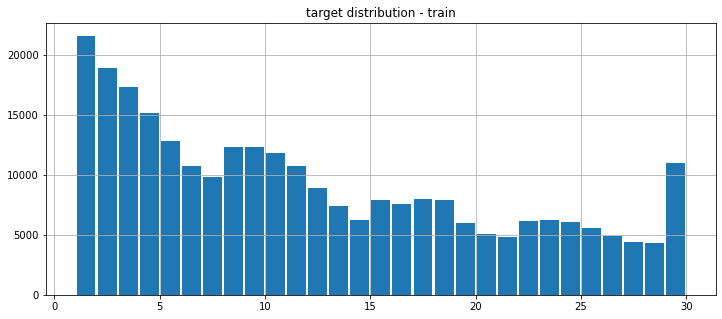

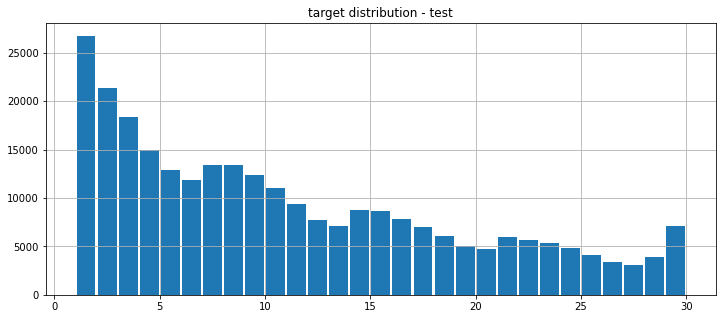

In [12]:
plt.figure(figsize=(12,5))
plt.hist(dataset.query("fold==0")[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - train")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(dataset.query("fold==1")[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - test")
plt.grid()
plt.show()

In [13]:
print("Uncensored rows (train):", len(dataset.query("fold==0").query("inventory_days > 30")) / 1e3)
print("Uncensored rows (valid):", len(dataset.query("fold==1").query("inventory_days > 30")) / 1e3)

Uncensored rows (train): 0.0
Uncensored rows (valid): 0.0


In [14]:
dataset.query("sku not in @skus_to_remove").sku.nunique()

272130

In [15]:
skus_assess_m2 = dataset.query("sku not in @skus_to_remove").sku.unique().tolist()

with open("../data/skus_assess_m2.yaml", "w") as file:
    yaml.dump(skus_assess_m2, file)
    file.close()

***
## model training: assessment

In [16]:
model_params = {
    'booster': 'gbtree',
    #'sample_type': 'uniform',
    #'normalize_type': 'tree',
    #'rate_drop': 0.1,
    # 'skip_drop': 0.75,
    
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    #'aft_loss_distribution': 'normal',
    'aft_loss_distribution': 'logistic',
    #'aft_loss_distribution': 'extreme',
    'aft_loss_distribution_scale': 1.4,
    
    #'tree_method': 'exact',
    #'tree_method': 'approx',
    'tree_method': 'hist',
    'max_bin': 256,
    
    'grow_policy': 'lossguide',
    'max_leaves': 2**6-1,
    'min_child_weight': 50,
    'max_depth': 8,
    
    'learning_rate': 0.05,
    'max_delta_step':.5,
    
    'colsample_bytree':0.8,
    'subsample':0.95,
    
    'lambda':0.1,
    'seed':SEED,
}

------------------------------------------------------------------------------------------
Training model for site: MLA 

Training with fold 0
[0]	valid-aft-nloglik:4.47503
[25]	valid-aft-nloglik:4.19489
[50]	valid-aft-nloglik:3.97659
[75]	valid-aft-nloglik:3.83165
[100]	valid-aft-nloglik:3.75502
[125]	valid-aft-nloglik:3.72799
[150]	valid-aft-nloglik:3.72298
[175]	valid-aft-nloglik:3.72228
[200]	valid-aft-nloglik:3.72227
[225]	valid-aft-nloglik:3.72232
[239]	valid-aft-nloglik:3.72237


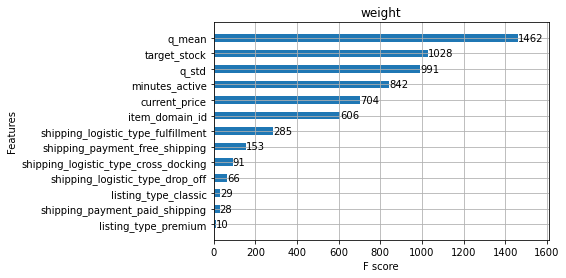

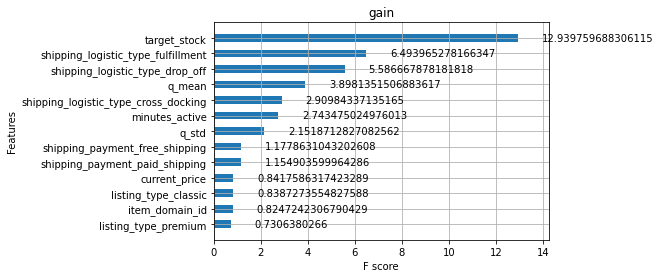

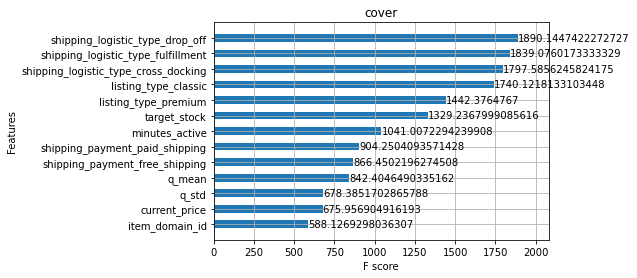

Training with fold 1
[0]	valid-aft-nloglik:4.61380
[25]	valid-aft-nloglik:4.32718
[50]	valid-aft-nloglik:4.10040
[75]	valid-aft-nloglik:3.94578
[100]	valid-aft-nloglik:3.86150
[125]	valid-aft-nloglik:3.83056
[150]	valid-aft-nloglik:3.82351
[175]	valid-aft-nloglik:3.82200
[200]	valid-aft-nloglik:3.82172
[225]	valid-aft-nloglik:3.82146
[250]	valid-aft-nloglik:3.82132
[275]	valid-aft-nloglik:3.82114
[300]	valid-aft-nloglik:3.82118
[325]	valid-aft-nloglik:3.82127
[336]	valid-aft-nloglik:3.82119


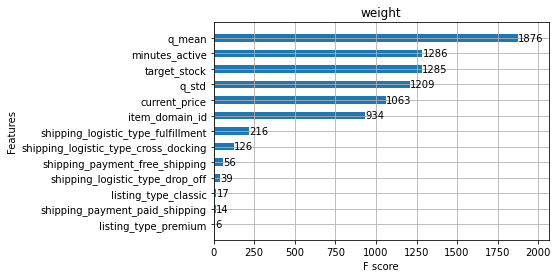

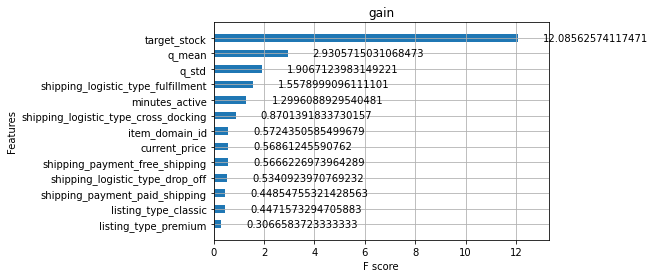

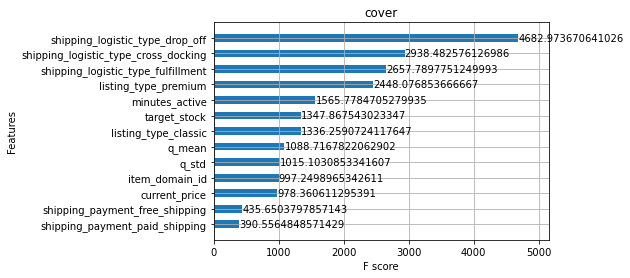

------------------------------------------------------------------------------------------
Training model for site: MLB 

Training with fold 0
[0]	valid-aft-nloglik:4.57953
[25]	valid-aft-nloglik:4.29325
[50]	valid-aft-nloglik:4.06726
[75]	valid-aft-nloglik:3.91343
[100]	valid-aft-nloglik:3.83025
[125]	valid-aft-nloglik:3.79992
[150]	valid-aft-nloglik:3.79367
[175]	valid-aft-nloglik:3.79240
[200]	valid-aft-nloglik:3.79209
[225]	valid-aft-nloglik:3.79195
[250]	valid-aft-nloglik:3.79190
[275]	valid-aft-nloglik:3.79190
[300]	valid-aft-nloglik:3.79190
[325]	valid-aft-nloglik:3.79191
[342]	valid-aft-nloglik:3.79191


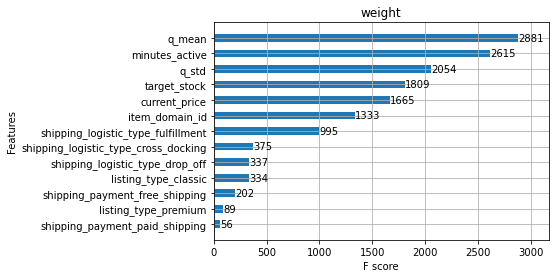

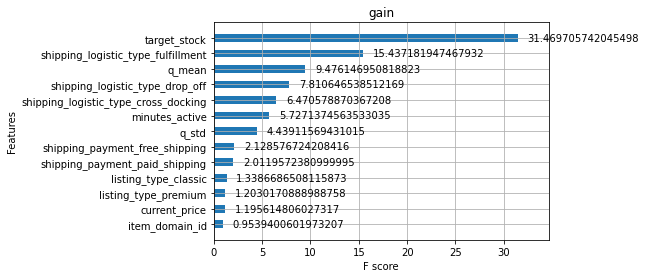

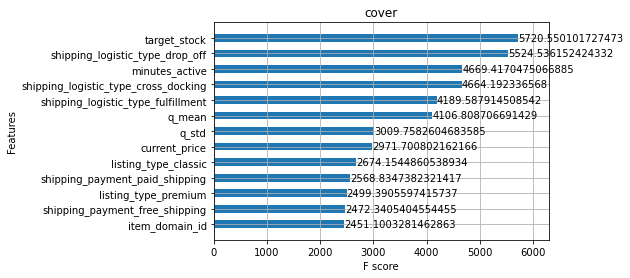

Training with fold 1
[0]	valid-aft-nloglik:4.76002
[25]	valid-aft-nloglik:4.46292
[50]	valid-aft-nloglik:4.22346
[75]	valid-aft-nloglik:4.05485
[100]	valid-aft-nloglik:3.95998
[125]	valid-aft-nloglik:3.92403
[150]	valid-aft-nloglik:3.91549
[175]	valid-aft-nloglik:3.91296
[200]	valid-aft-nloglik:3.91240
[225]	valid-aft-nloglik:3.91224
[250]	valid-aft-nloglik:3.91218
[275]	valid-aft-nloglik:3.91210
[300]	valid-aft-nloglik:3.91209
[325]	valid-aft-nloglik:3.91207
[350]	valid-aft-nloglik:3.91206
[375]	valid-aft-nloglik:3.91210
[398]	valid-aft-nloglik:3.91212


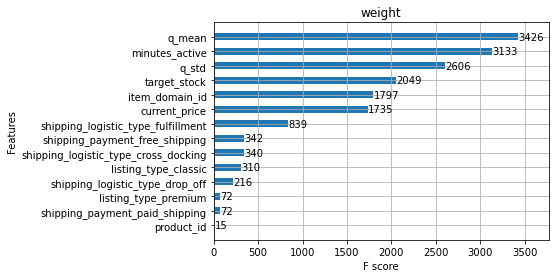

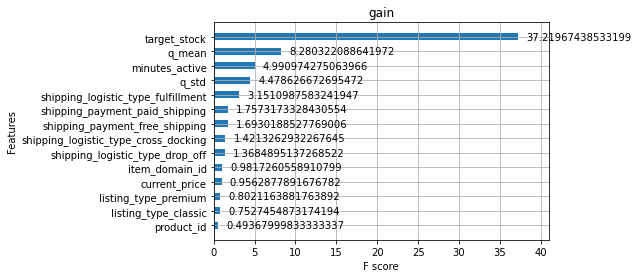

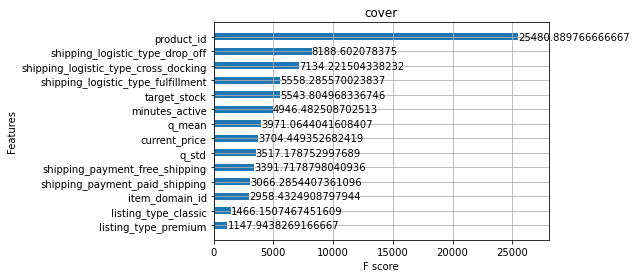

------------------------------------------------------------------------------------------
Training model for site: MLM 

Training with fold 0
[0]	valid-aft-nloglik:4.52822
[25]	valid-aft-nloglik:4.24551
[50]	valid-aft-nloglik:4.02387
[75]	valid-aft-nloglik:3.87460
[100]	valid-aft-nloglik:3.79368
[125]	valid-aft-nloglik:3.76437
[150]	valid-aft-nloglik:3.75864
[175]	valid-aft-nloglik:3.75751
[200]	valid-aft-nloglik:3.75726
[225]	valid-aft-nloglik:3.75720
[250]	valid-aft-nloglik:3.75716
[275]	valid-aft-nloglik:3.75715
[300]	valid-aft-nloglik:3.75716
[325]	valid-aft-nloglik:3.75716
[331]	valid-aft-nloglik:3.75718


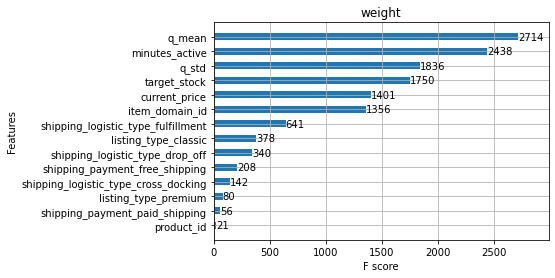

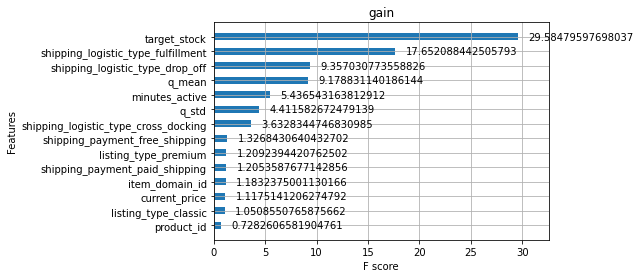

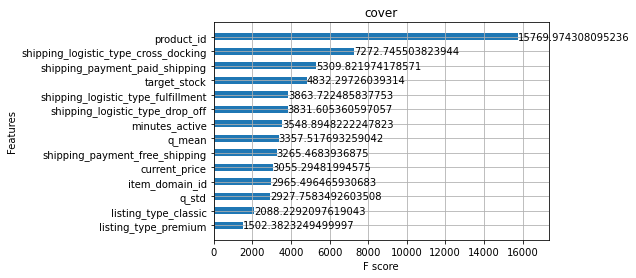

Training with fold 1
[0]	valid-aft-nloglik:4.69062
[25]	valid-aft-nloglik:4.39771
[50]	valid-aft-nloglik:4.16346
[75]	valid-aft-nloglik:4.00066
[100]	valid-aft-nloglik:3.91005
[125]	valid-aft-nloglik:3.87609
[150]	valid-aft-nloglik:3.86826
[175]	valid-aft-nloglik:3.86648
[200]	valid-aft-nloglik:3.86602
[225]	valid-aft-nloglik:3.86586
[250]	valid-aft-nloglik:3.86559
[275]	valid-aft-nloglik:3.86557
[300]	valid-aft-nloglik:3.86554
[325]	valid-aft-nloglik:3.86555
[331]	valid-aft-nloglik:3.86557


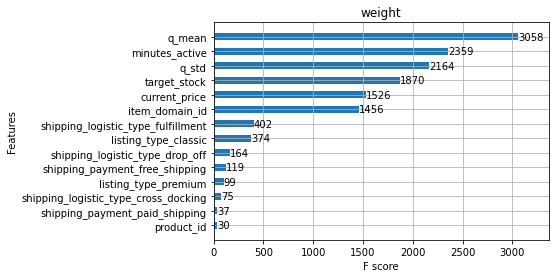

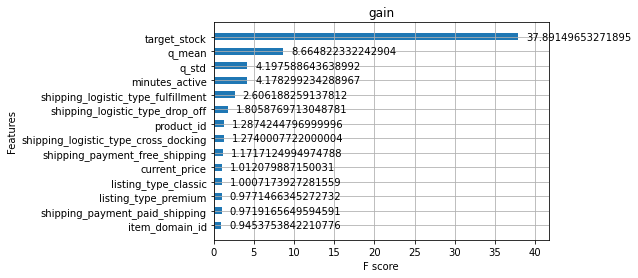

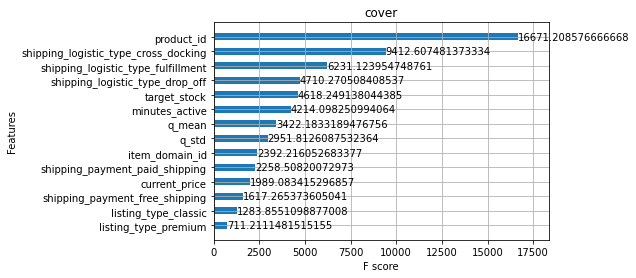

In [18]:
sites = ["MLA","MLB","MLM"]
models_by_site = {"MLA":list(), "MLB":list(), "MLM":list(),}
oof_preds = {"MLA":list(), "MLB":list(), "MLM":list(),}

for site in sites:
    print("-"*90)
    print(f"Training model for site: {site} \n")
    
    for fold in range(2):
        print(f"Training with fold {fold}")
    
        train_dset = (
            dataset
            .query("site_id == @site")
            .query("fold == @fold")
            .reset_index(drop=True)
        )
        valid_dset = (
            dataset
            .query("site_id == @site")
            .query("fold != @fold")
            .reset_index(drop=True)
        )
        
        encoder = ce.CatBoostEncoder()
        train_dset[categs_cols] = encoder.fit_transform(
            train_dset[categs_cols], 
            train_dset.eval("target_stock / inventory_days")
        )
        valid_dset[categs_cols] = encoder.transform(valid_dset[categs_cols])

        # train data matrix
        dtrain = xgb.DMatrix(
            data = train_dset.loc[:, numeric_cols+categs_cols], 
        )
        dtrain.set_float_info('label_lower_bound', train_dset.id_lower.values)
        dtrain.set_float_info('label_upper_bound', train_dset.id_upper.values)
        
        # sample of train data matrix for metric tracking
        sample_index = train_dset.sample(frac=0.25).index
        dtrain_sample = xgb.DMatrix(
            data = train_dset.loc[sample_index, numeric_cols+categs_cols],
        )
        dtrain_sample.set_float_info('label_lower_bound', train_dset.loc[sample_index].id_lower.values)
        dtrain_sample.set_float_info('label_upper_bound', train_dset.loc[sample_index].id_upper.values)

        # valid data matrix
        dvalid = xgb.DMatrix(
            data = valid_dset.loc[:, numeric_cols+categs_cols],
        )
        dvalid.set_float_info('label_lower_bound', valid_dset.id_lower.values)
        dvalid.set_float_info('label_upper_bound', valid_dset.id_upper.values)

        model = xgb.train(
            params = model_params,
            dtrain = dtrain,
            evals = [
                (dvalid,"valid"), 
                #(dtrain_sample,"train_sample")
            ],
            num_boost_round = 5000,
            early_stopping_rounds = 50,
            verbose_eval = 25,
        )

        xgb.plot_importance(model, height=0.5, importance_type="weight", title="weight")
        xgb.plot_importance(model, height=0.5, importance_type="gain", title="gain")
        xgb.plot_importance(model, height=0.5, importance_type="cover", title="cover")
        plt.show()

        valid_dset["pred"] = np.clip(model.predict(dvalid), a_min=None, a_max=30)
        valid_dset = binarize_predictions(valid_dset)
        oof_preds[site].append(valid_dset)
        models_by_site[site].append(model)

In [19]:
for site in sites:
    for fold,(oof,model) in enumerate(zip(oof_preds[site],models_by_site[site])):
        mean_ae = oof.query("sku not in @skus_to_remove").eval("abs(inventory_days - pred)").mean()
        median_ae = oof.query("sku not in @skus_to_remove").eval("abs(inventory_days - pred)").median()
        print(
            site, "-", f"train_fold={fold}", "-",
            f"best_iteration: {model.best_iteration}", "-",
            f"best_score: {model.best_score:0.4f}", "-", 
            f"mean_ae: {mean_ae:0.4f}", "-",
            f"median_ae: {median_ae:0.4f}",
        )
    print()

MLA - train_fold=0 - best_iteration: 190 - best_score: 3.7222 - mean_ae: 4.5073 - median_ae: 3.3078
MLA - train_fold=1 - best_iteration: 286 - best_score: 3.8211 - mean_ae: 5.4784 - median_ae: 3.6942

MLB - train_fold=0 - best_iteration: 293 - best_score: 3.7919 - mean_ae: 4.7883 - median_ae: 3.5167
MLB - train_fold=1 - best_iteration: 349 - best_score: 3.9121 - mean_ae: 5.3313 - median_ae: 3.7724

MLM - train_fold=0 - best_iteration: 282 - best_score: 3.7571 - mean_ae: 4.6992 - median_ae: 3.4172
MLM - train_fold=1 - best_iteration: 282 - best_score: 3.8655 - mean_ae: 5.2186 - median_ae: 3.5788



In [20]:
oof0 = pd.concat([
    oof_preds["MLA"][0][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLB"][0][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLM"][0][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    ], ignore_index=True
)
oof0["valid_fold"] = oof0["valid_fold"].astype(int)

oof1 = pd.concat([
    oof_preds["MLA"][1][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLB"][1][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLM"][1][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    ], ignore_index=True
)
oof1["valid_fold"] = oof1["valid_fold"].astype(int)

In [21]:
print("Overall Mean AE on fold1:  ", oof0.eval("abs(inventory_days-pred)").mean())
print("Overall Median AE on fold1:", oof0.eval("abs(inventory_days-pred)").median())

Overall Mean AE on fold1:   4.726693979080135
Overall Median AE on fold1: 3.455824851989746


In [22]:
print("Overall Mean AE on fold0:  ", oof1.eval("abs(inventory_days-pred)").mean())
print("Overall Median AE on fold0:", oof1.eval("abs(inventory_days-pred)").median())

Overall Mean AE on fold0:   5.2978386266585575
Overall Median AE on fold0: 3.6864402294158936


In [23]:
oof_concat = pd.concat([oof0,oof1], ignore_index=True)
oof_concat.to_csv("../results/oof_preds_xgb-m2.csv", index=False)

***
## analysis of OOF predictions

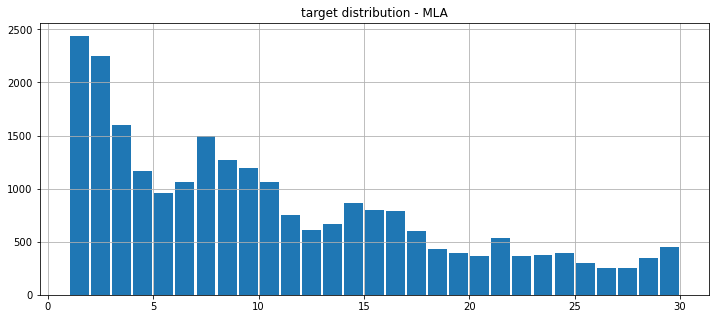

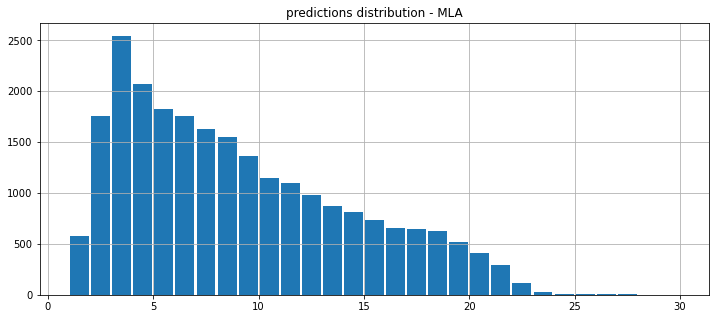

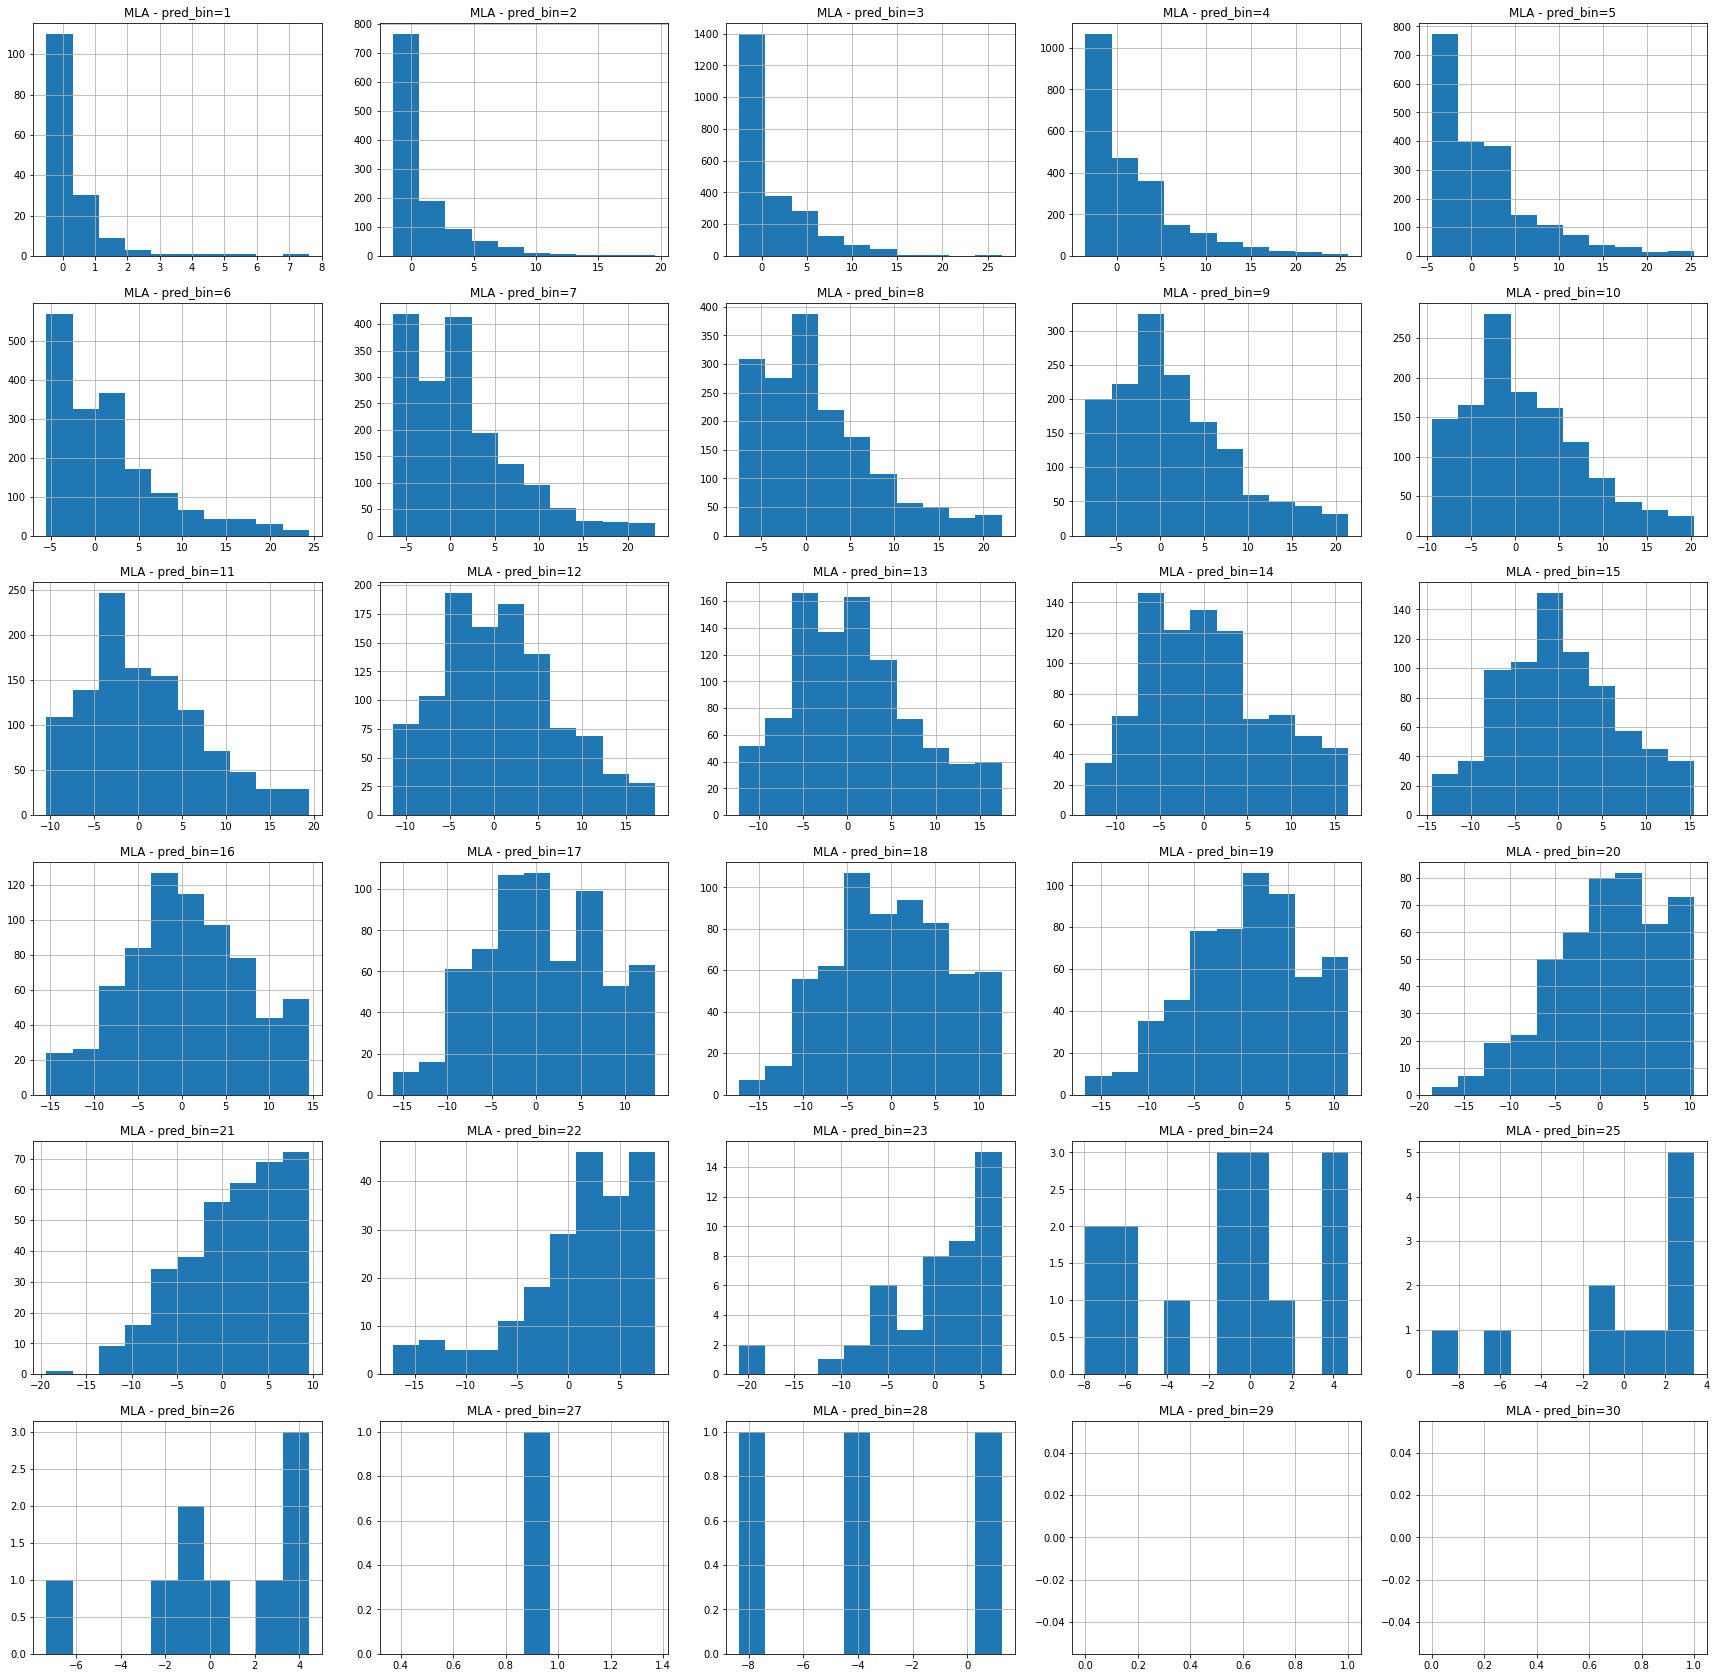

In [24]:
# results for MLA
site = "MLA"
train_fold = 0

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"target distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"predictions distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[site][train_fold].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"{site} - pred_bin={d}")
    plt.grid()
plt.show()

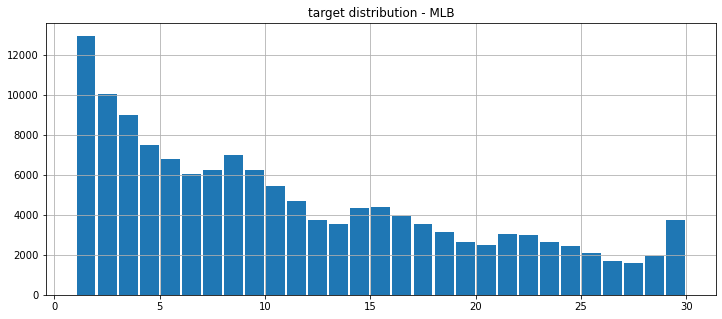

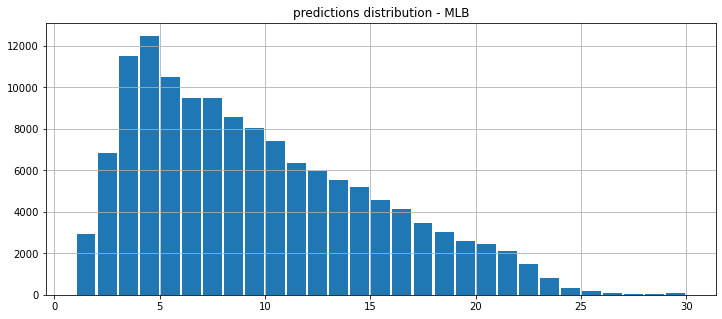

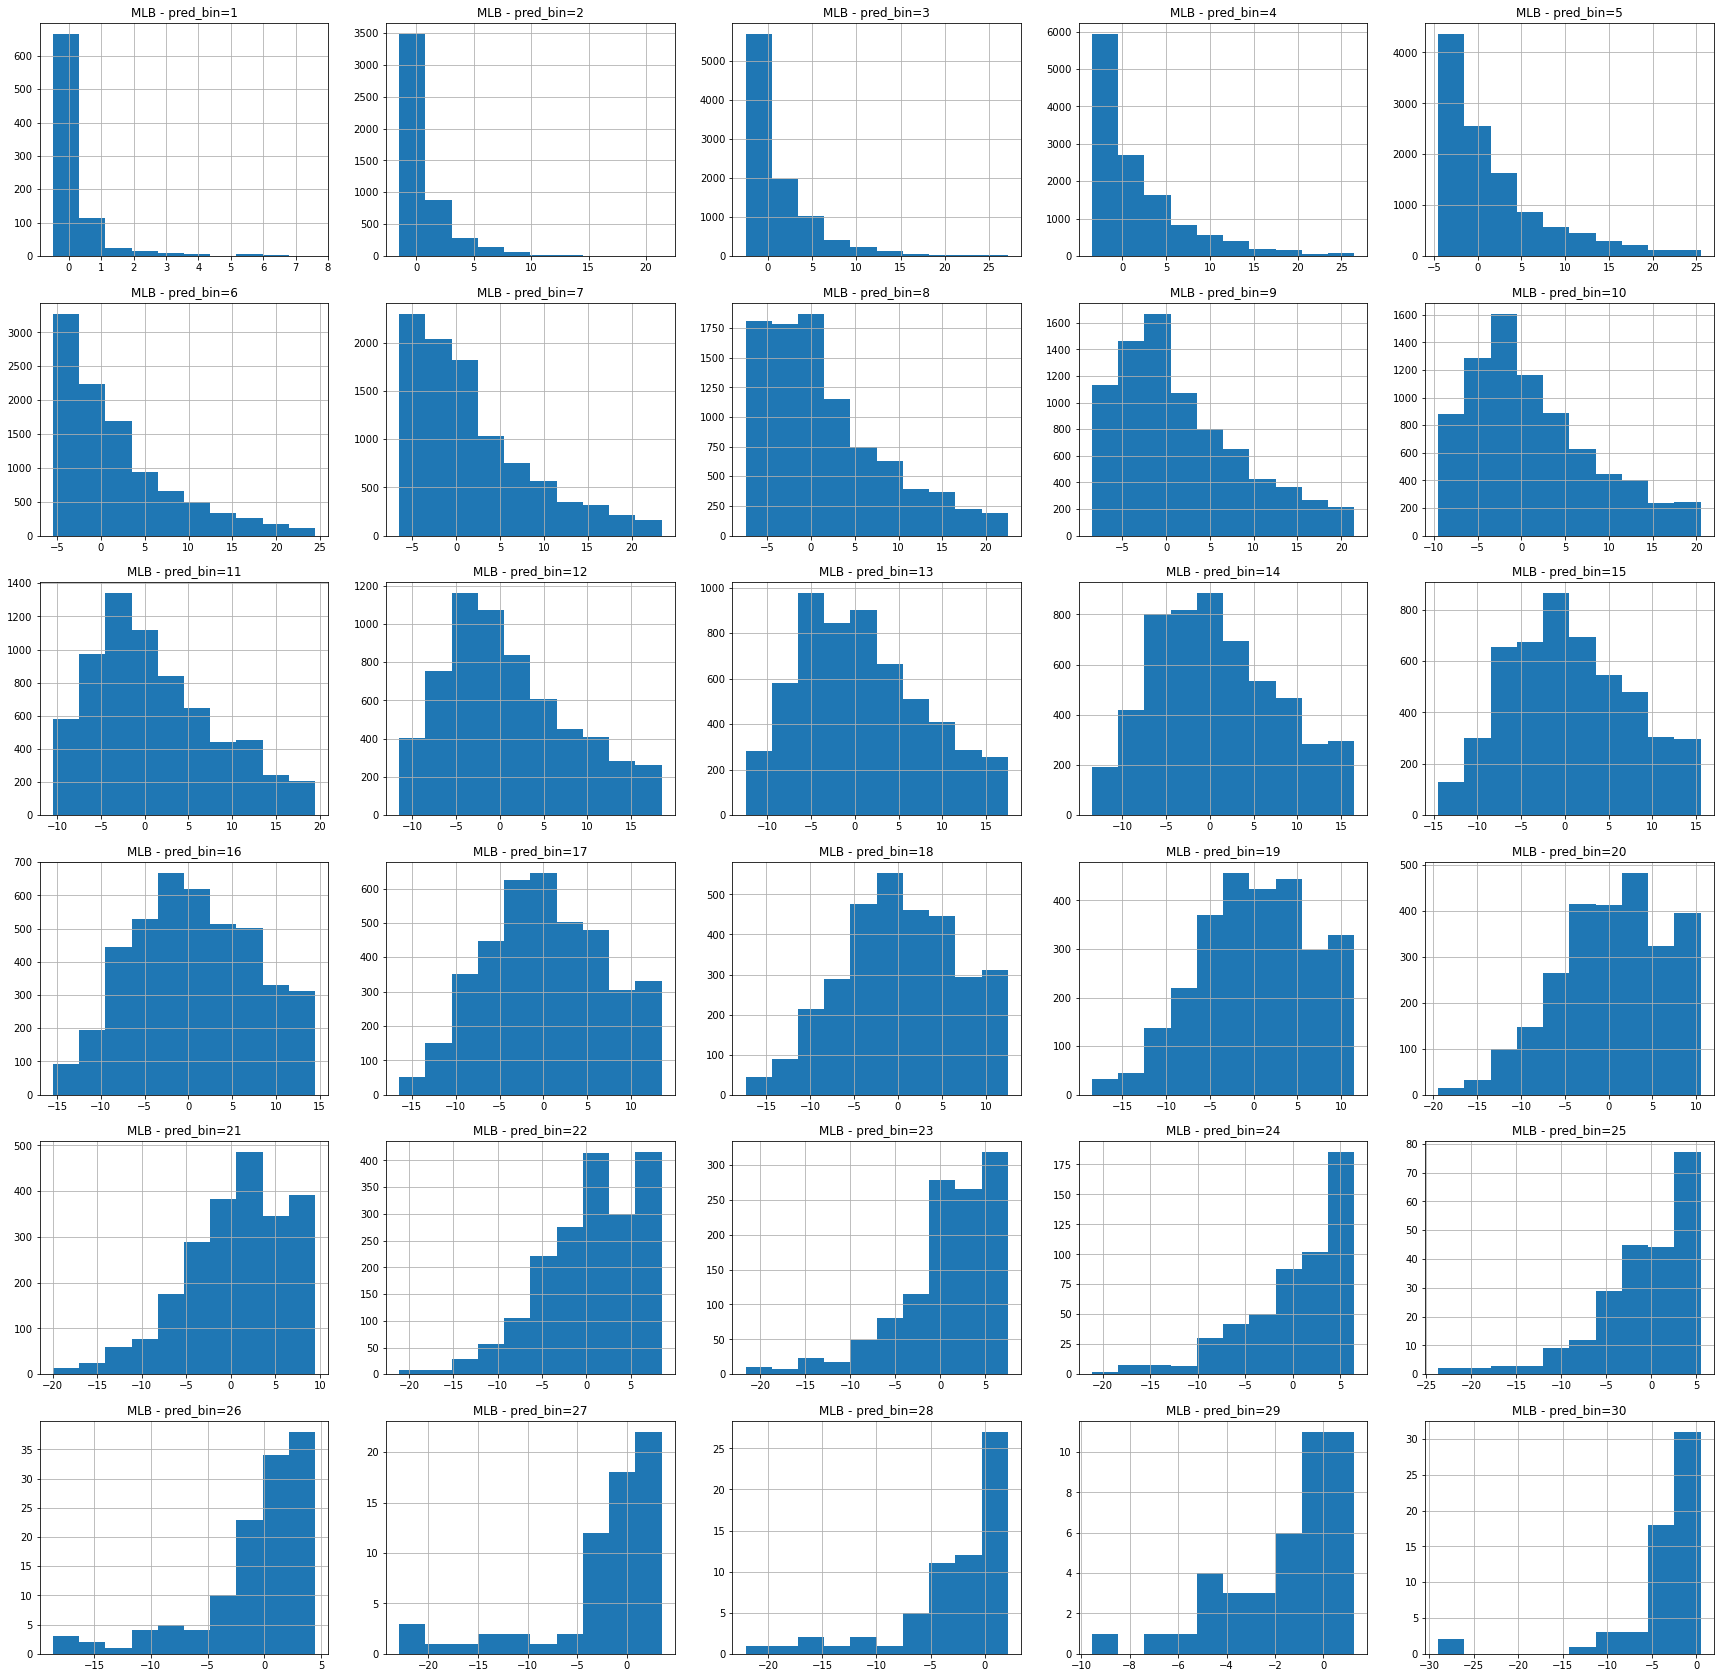

In [25]:
# results for MLB
site = "MLB"
train_fold = 0

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"target distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"predictions distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[site][train_fold].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"{site} - pred_bin={d}")
    plt.grid()
plt.show()

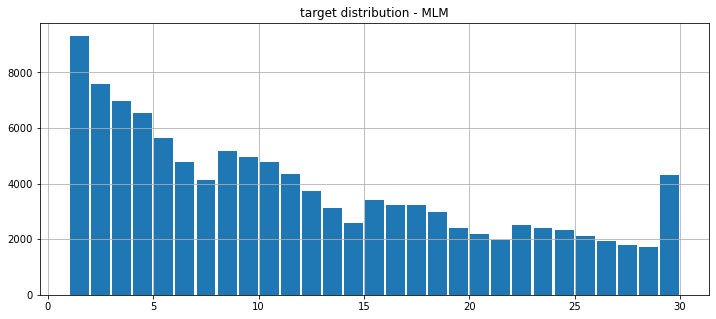

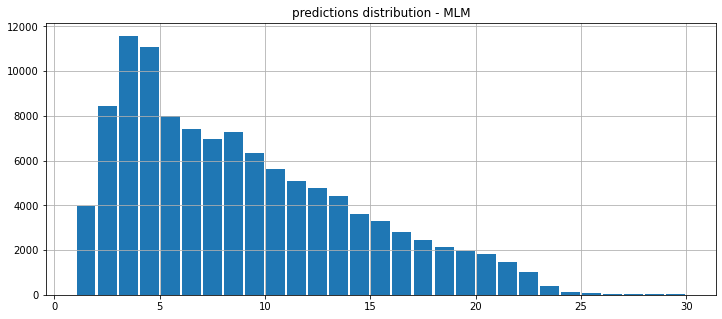

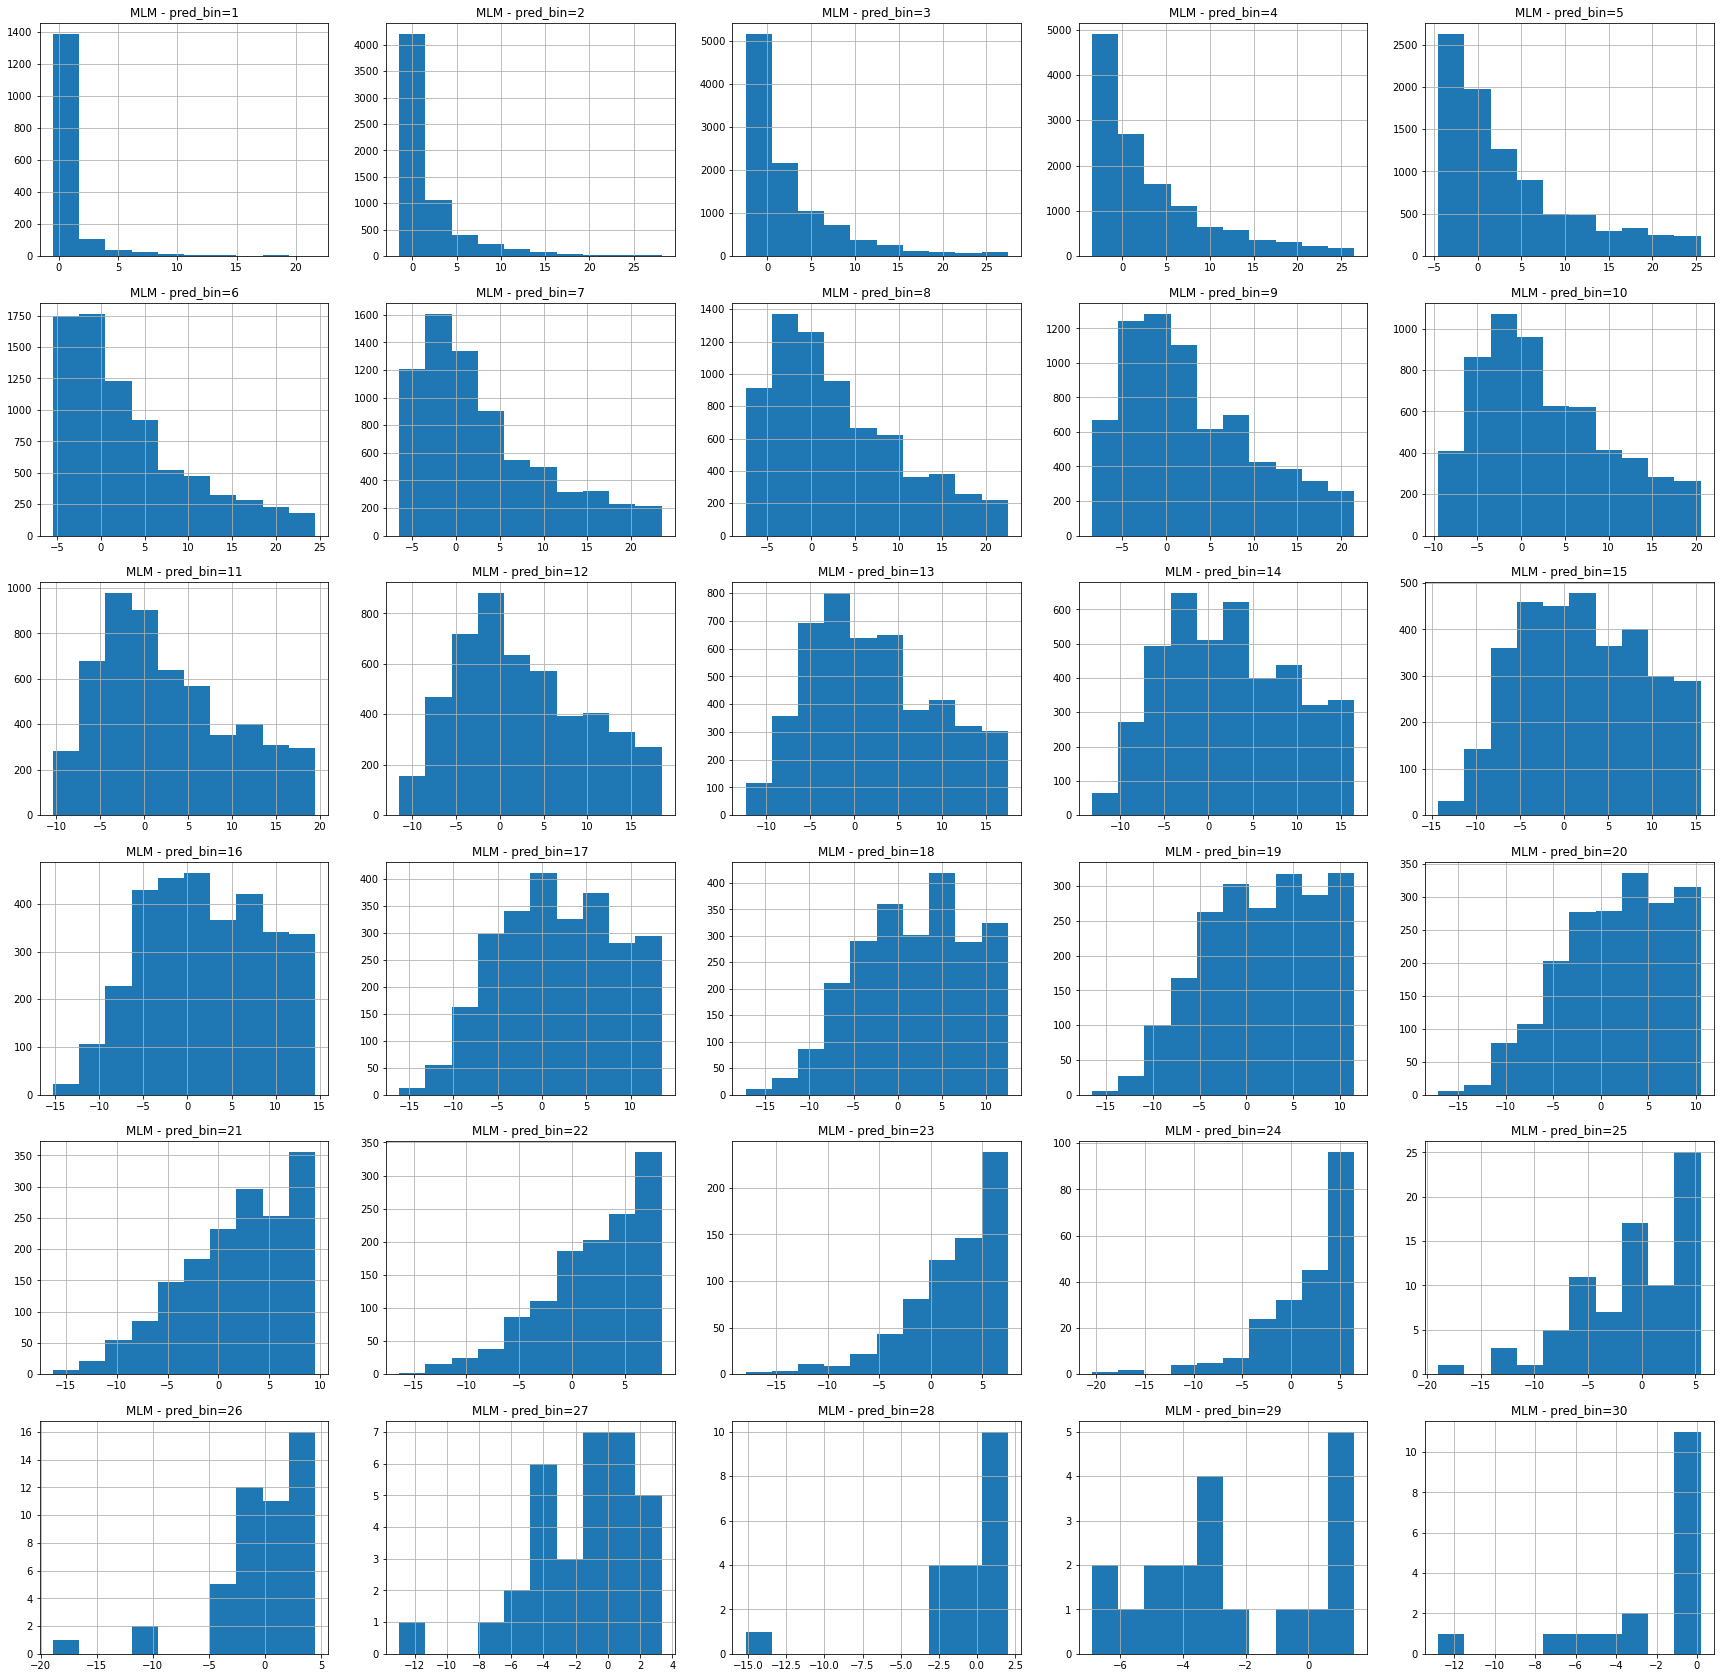

In [26]:
# results for MLM
site = "MLM"
train_fold = 1

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"target distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"predictions distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[site][train_fold].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"{site} - pred_bin={d}")
    plt.grid()
plt.show()

***
## model training

In [27]:
dataset = (
    pd.read_parquet(f"{input_path}/train-m2.parquet")
    .query("inventory_days <= 30")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
dataset["nrows"] = dataset.groupby("sku")["ds"].transform("count")
print("n rows:", len(dataset) / 1e6)
print("n skus:", dataset.sku.nunique() / 1e3)

n rows: 10.51947
n skus: 441.834


In [34]:
test = pd.read_parquet(f"{input_path}/test-m2.parquet")

print("n rows:", len(test) / 1e3)
print("n skus:", test.sku.nunique() / 1e3)

n rows: 441.834
n skus: 441.834


In [28]:
dataset["id_lower"] = dataset["inventory_days"].copy() 
dataset["id_upper"] = dataset["inventory_days"].copy()

idx = dataset.query("inventory_days > 30").index
dataset.loc[idx,"id_lower"] = 30
dataset.loc[idx,"id_upper"] = np.inf

print("n of uncensored:", len(idx)/1e3)

n of uncensored: 0.0


In [29]:
encoder = ce.CatBoostEncoder()
dataset[categs_cols] = encoder.fit_transform(
    dataset[categs_cols], 
    dataset.eval("target_stock / inventory_days")
)

test[categs_cols] = encoder.transform(test[categs_cols])

------------------------------------------------------------------------------------------
Training model for site: MLA
Training model for seed: 2 

[0]	train_sample-aft-nloglik:4.87874
[25]	train_sample-aft-nloglik:4.57464
[50]	train_sample-aft-nloglik:4.32631
[75]	train_sample-aft-nloglik:4.14641
[100]	train_sample-aft-nloglik:4.03868
[125]	train_sample-aft-nloglik:3.99231
[150]	train_sample-aft-nloglik:3.98036
[175]	train_sample-aft-nloglik:3.97804
[200]	train_sample-aft-nloglik:3.97710
[225]	train_sample-aft-nloglik:3.97650
[249]	train_sample-aft-nloglik:3.97609


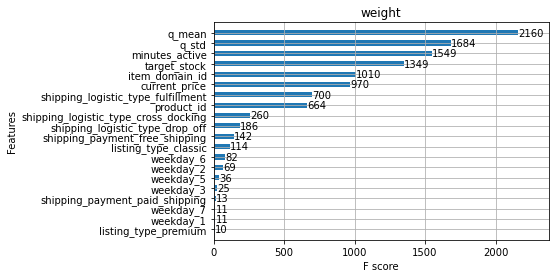

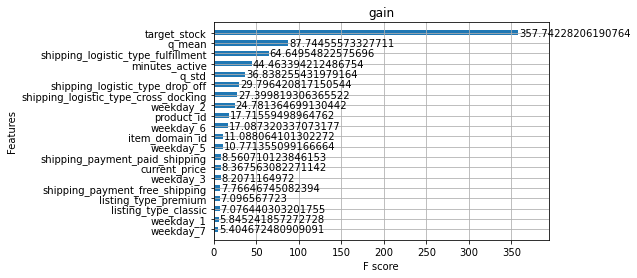

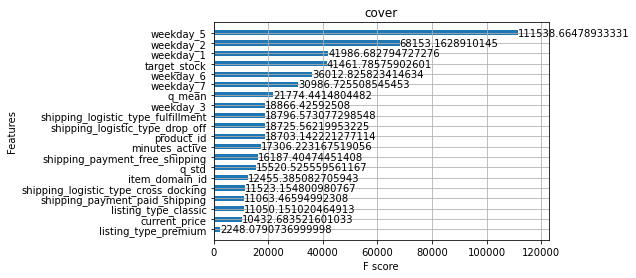

Elapsed time for model training: 0.3465840816497803 min
Training model for seed: 11 

[0]	train_sample-aft-nloglik:4.87874
[25]	train_sample-aft-nloglik:4.57464
[50]	train_sample-aft-nloglik:4.32631
[75]	train_sample-aft-nloglik:4.14637
[100]	train_sample-aft-nloglik:4.03940
[125]	train_sample-aft-nloglik:3.99318
[150]	train_sample-aft-nloglik:3.98080
[175]	train_sample-aft-nloglik:3.97824
[200]	train_sample-aft-nloglik:3.97716
[225]	train_sample-aft-nloglik:3.97653
[249]	train_sample-aft-nloglik:3.97611


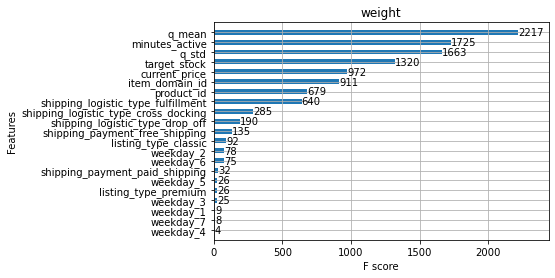

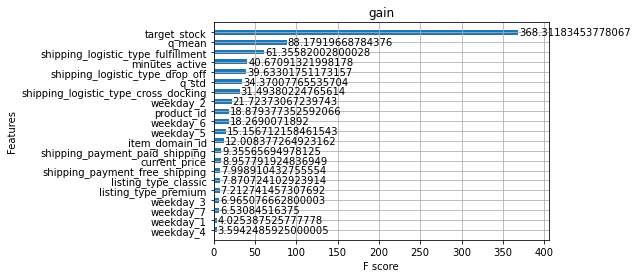

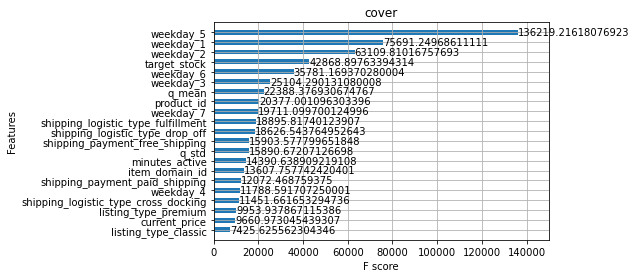

Elapsed time for model training: 0.5419081807136535 min
Training model for seed: 19 

[0]	train_sample-aft-nloglik:4.87874
[25]	train_sample-aft-nloglik:4.57464
[50]	train_sample-aft-nloglik:4.32631
[75]	train_sample-aft-nloglik:4.14649
[100]	train_sample-aft-nloglik:4.03839
[125]	train_sample-aft-nloglik:3.99167
[150]	train_sample-aft-nloglik:3.98056
[175]	train_sample-aft-nloglik:3.97802
[200]	train_sample-aft-nloglik:3.97706
[225]	train_sample-aft-nloglik:3.97651
[249]	train_sample-aft-nloglik:3.97610


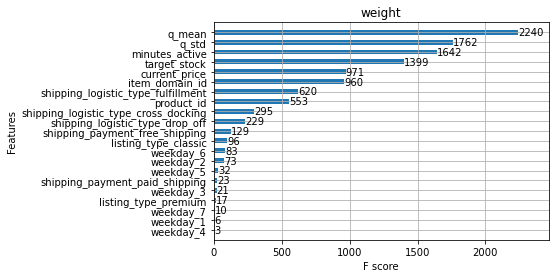

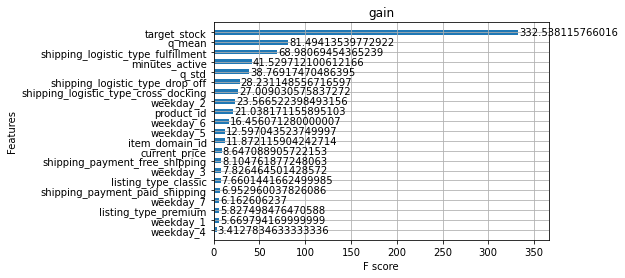

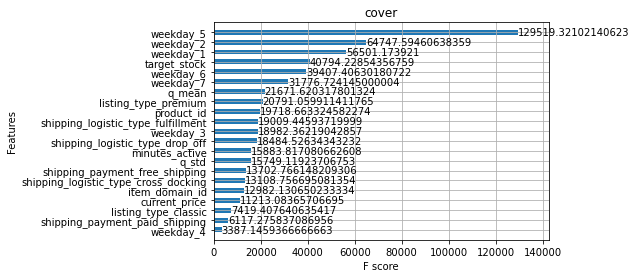

Elapsed time for model training: 0.656164801120758 min
Training model for seed: 23 

[0]	train_sample-aft-nloglik:4.87874
[25]	train_sample-aft-nloglik:4.57464
[50]	train_sample-aft-nloglik:4.32631
[75]	train_sample-aft-nloglik:4.14635
[100]	train_sample-aft-nloglik:4.03966
[125]	train_sample-aft-nloglik:3.99305
[150]	train_sample-aft-nloglik:3.98081
[175]	train_sample-aft-nloglik:3.97816
[200]	train_sample-aft-nloglik:3.97716
[225]	train_sample-aft-nloglik:3.97659
[249]	train_sample-aft-nloglik:3.97615


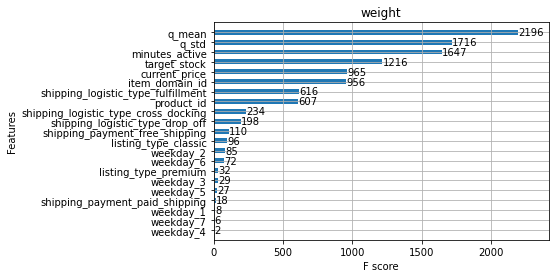

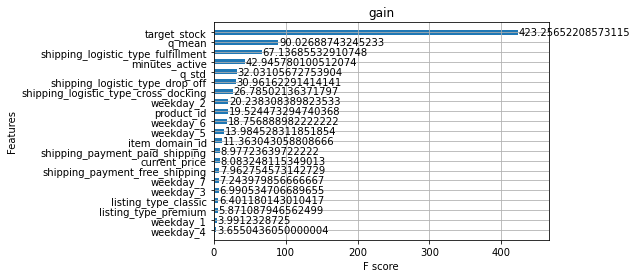

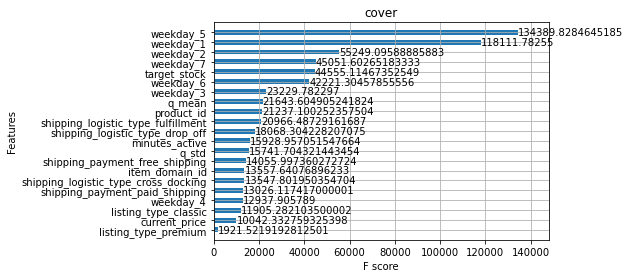

Elapsed time for model training: 0.6443655808766683 min
Training model for seed: 41 

[0]	train_sample-aft-nloglik:4.87874
[25]	train_sample-aft-nloglik:4.57464
[50]	train_sample-aft-nloglik:4.32631
[75]	train_sample-aft-nloglik:4.14643
[100]	train_sample-aft-nloglik:4.03914
[125]	train_sample-aft-nloglik:3.99303
[150]	train_sample-aft-nloglik:3.98168
[175]	train_sample-aft-nloglik:3.97817
[200]	train_sample-aft-nloglik:3.97715
[225]	train_sample-aft-nloglik:3.97656
[249]	train_sample-aft-nloglik:3.97616


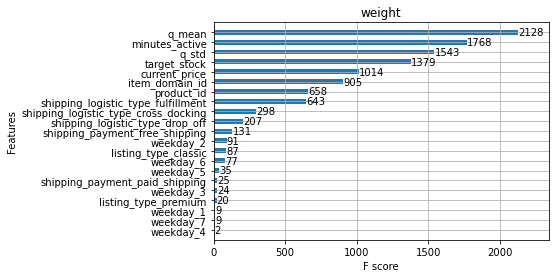

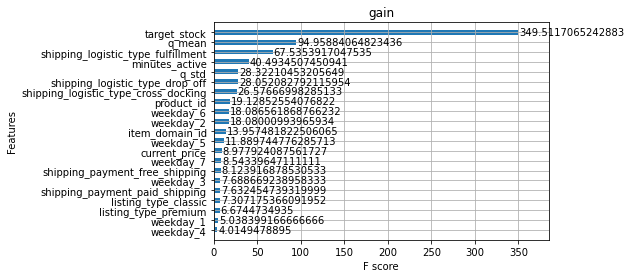

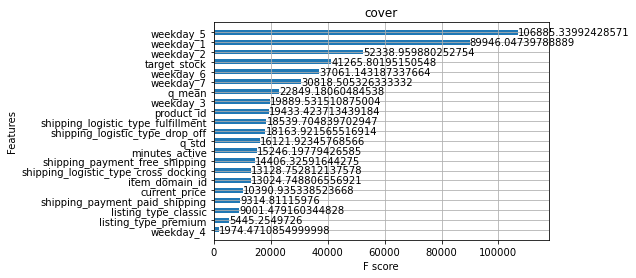

Elapsed time for model training: 0.6169124841690063 min
------------------------------------------------------------------------------------------
Training model for site: MLB
Training model for seed: 2 

[0]	train_sample-aft-nloglik:4.91434
[25]	train_sample-aft-nloglik:4.60822
[50]	train_sample-aft-nloglik:4.35735
[75]	train_sample-aft-nloglik:4.17453
[100]	train_sample-aft-nloglik:4.06464
[125]	train_sample-aft-nloglik:4.01753
[150]	train_sample-aft-nloglik:4.00548
[175]	train_sample-aft-nloglik:4.00327
[200]	train_sample-aft-nloglik:4.00254
[225]	train_sample-aft-nloglik:4.00216
[250]	train_sample-aft-nloglik:4.00192
[275]	train_sample-aft-nloglik:4.00174
[299]	train_sample-aft-nloglik:4.00160


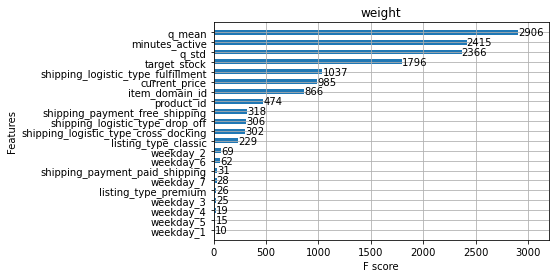

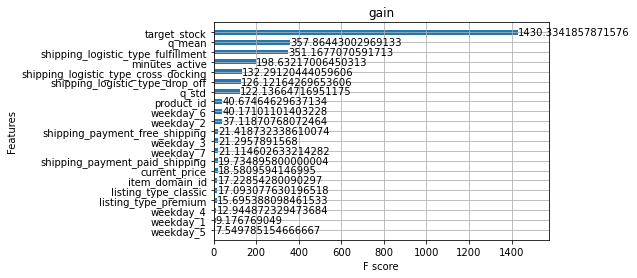

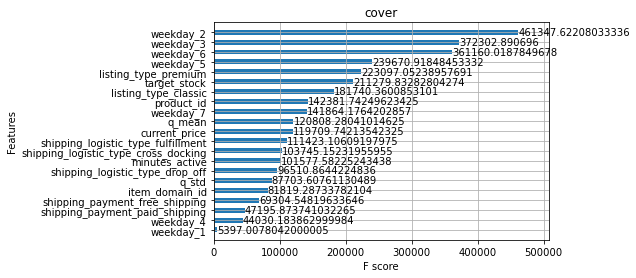

Elapsed time for model training: 3.865495916207631 min
Training model for seed: 11 

[0]	train_sample-aft-nloglik:4.91434
[25]	train_sample-aft-nloglik:4.60822
[50]	train_sample-aft-nloglik:4.35735
[75]	train_sample-aft-nloglik:4.17455
[100]	train_sample-aft-nloglik:4.06529
[125]	train_sample-aft-nloglik:4.01840
[150]	train_sample-aft-nloglik:4.00591
[175]	train_sample-aft-nloglik:4.00348
[200]	train_sample-aft-nloglik:4.00260
[225]	train_sample-aft-nloglik:4.00217
[250]	train_sample-aft-nloglik:4.00192
[275]	train_sample-aft-nloglik:4.00174
[299]	train_sample-aft-nloglik:4.00160


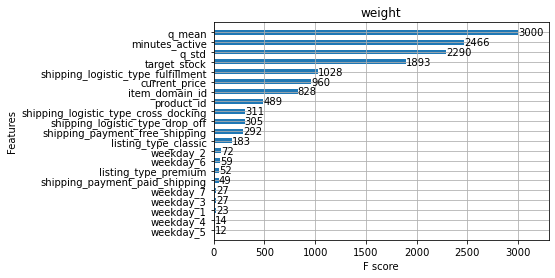

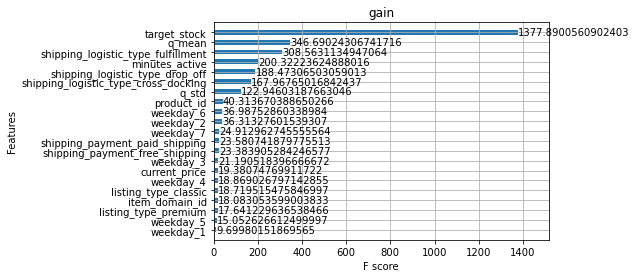

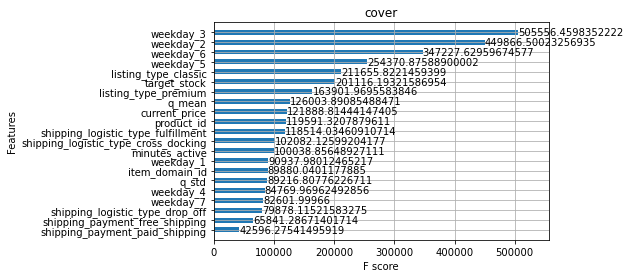

Elapsed time for model training: 4.27722464799881 min
Training model for seed: 19 

[0]	train_sample-aft-nloglik:4.91434
[25]	train_sample-aft-nloglik:4.60822
[50]	train_sample-aft-nloglik:4.35735
[75]	train_sample-aft-nloglik:4.17455
[100]	train_sample-aft-nloglik:4.06441
[125]	train_sample-aft-nloglik:4.01700
[150]	train_sample-aft-nloglik:4.00570
[175]	train_sample-aft-nloglik:4.00326
[200]	train_sample-aft-nloglik:4.00250
[225]	train_sample-aft-nloglik:4.00214
[250]	train_sample-aft-nloglik:4.00190
[275]	train_sample-aft-nloglik:4.00173
[299]	train_sample-aft-nloglik:4.00160


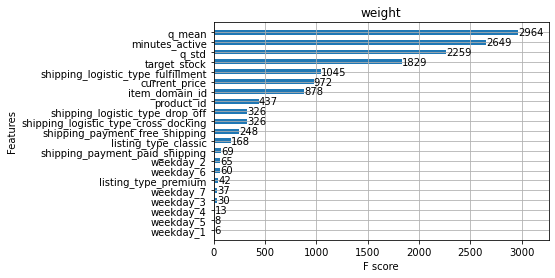

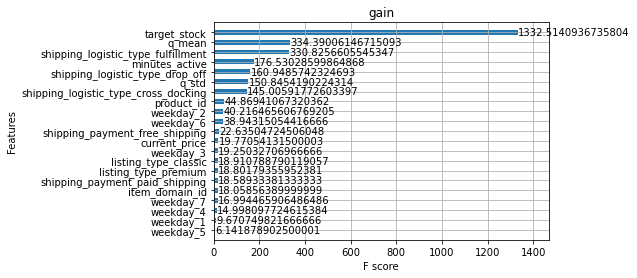

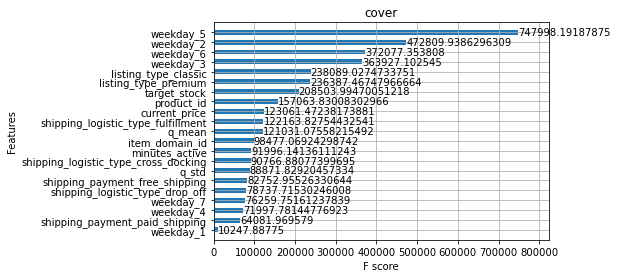

Elapsed time for model training: 4.524610082308452 min
Training model for seed: 23 

[0]	train_sample-aft-nloglik:4.91434
[25]	train_sample-aft-nloglik:4.60822
[50]	train_sample-aft-nloglik:4.35735
[75]	train_sample-aft-nloglik:4.17463
[100]	train_sample-aft-nloglik:4.06553
[125]	train_sample-aft-nloglik:4.01821
[150]	train_sample-aft-nloglik:4.00591
[175]	train_sample-aft-nloglik:4.00337
[200]	train_sample-aft-nloglik:4.00255
[225]	train_sample-aft-nloglik:4.00217
[250]	train_sample-aft-nloglik:4.00191
[275]	train_sample-aft-nloglik:4.00172
[299]	train_sample-aft-nloglik:4.00158


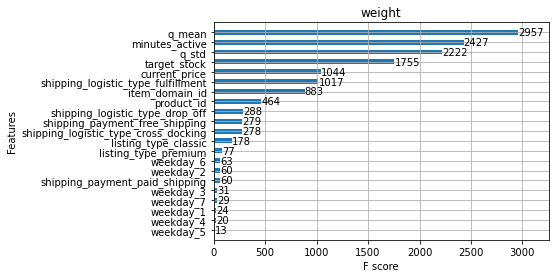

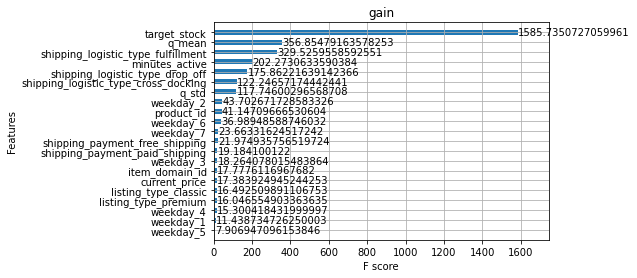

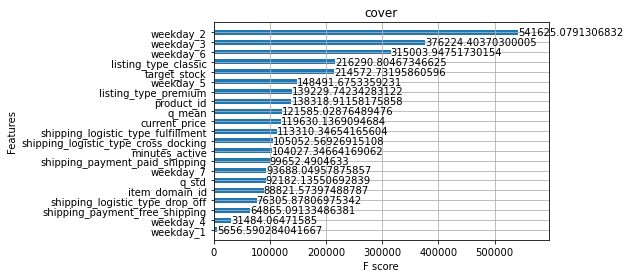

Elapsed time for model training: 4.357265714804331 min
Training model for seed: 41 

[0]	train_sample-aft-nloglik:4.91434
[25]	train_sample-aft-nloglik:4.60822
[50]	train_sample-aft-nloglik:4.35735
[75]	train_sample-aft-nloglik:4.17452
[100]	train_sample-aft-nloglik:4.06518
[125]	train_sample-aft-nloglik:4.01821
[150]	train_sample-aft-nloglik:4.00678
[175]	train_sample-aft-nloglik:4.00343
[200]	train_sample-aft-nloglik:4.00257
[225]	train_sample-aft-nloglik:4.00218
[250]	train_sample-aft-nloglik:4.00193
[275]	train_sample-aft-nloglik:4.00174
[299]	train_sample-aft-nloglik:4.00159


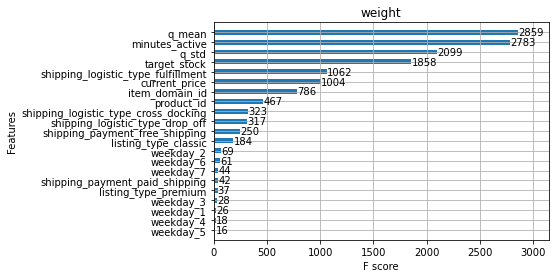

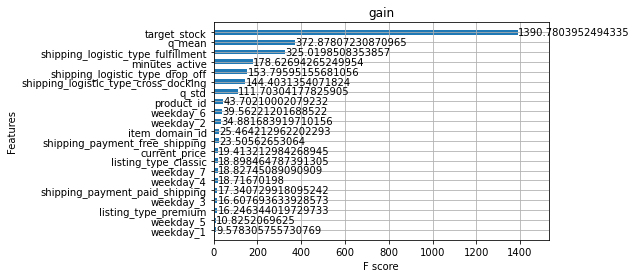

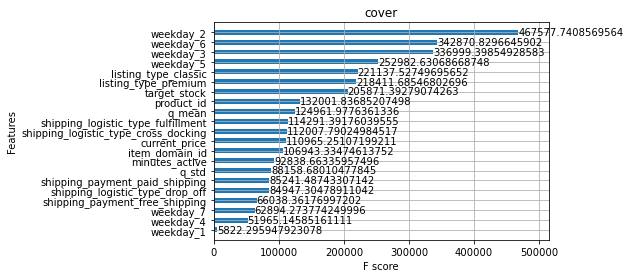

Elapsed time for model training: 4.202816017468771 min
------------------------------------------------------------------------------------------
Training model for site: MLM
Training model for seed: 2 

[0]	train_sample-aft-nloglik:4.78269
[25]	train_sample-aft-nloglik:4.48421
[50]	train_sample-aft-nloglik:4.24298
[75]	train_sample-aft-nloglik:4.07128
[100]	train_sample-aft-nloglik:3.97091
[125]	train_sample-aft-nloglik:3.92891
[150]	train_sample-aft-nloglik:3.91824
[175]	train_sample-aft-nloglik:3.91631
[200]	train_sample-aft-nloglik:3.91564
[225]	train_sample-aft-nloglik:3.91527
[250]	train_sample-aft-nloglik:3.91502
[275]	train_sample-aft-nloglik:3.91481
[299]	train_sample-aft-nloglik:3.91464


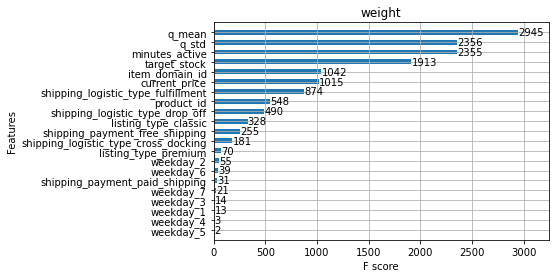

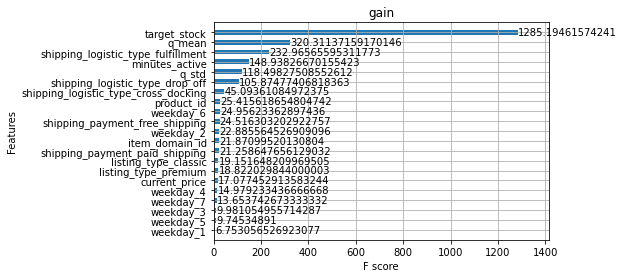

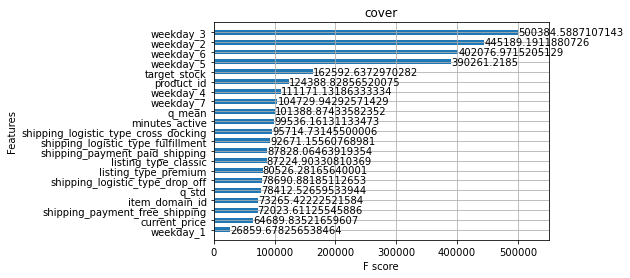

Elapsed time for model training: 3.525523479779561 min
Training model for seed: 11 

[0]	train_sample-aft-nloglik:4.78269
[25]	train_sample-aft-nloglik:4.48421
[50]	train_sample-aft-nloglik:4.24298
[75]	train_sample-aft-nloglik:4.07114
[100]	train_sample-aft-nloglik:3.97198
[125]	train_sample-aft-nloglik:3.92993
[150]	train_sample-aft-nloglik:3.91872
[175]	train_sample-aft-nloglik:3.91649
[200]	train_sample-aft-nloglik:3.91566
[225]	train_sample-aft-nloglik:3.91525
[250]	train_sample-aft-nloglik:3.91498
[275]	train_sample-aft-nloglik:3.91476
[299]	train_sample-aft-nloglik:3.91461


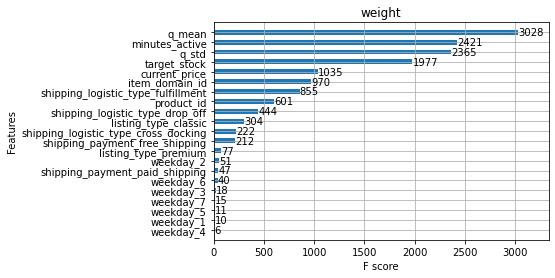

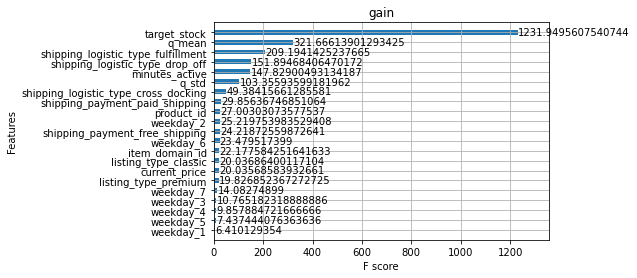

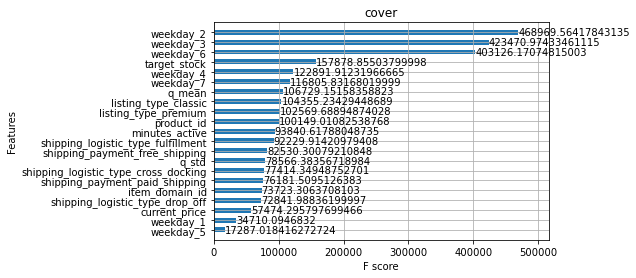

Elapsed time for model training: 4.027686333656311 min
Training model for seed: 19 

[0]	train_sample-aft-nloglik:4.78269
[25]	train_sample-aft-nloglik:4.48421
[50]	train_sample-aft-nloglik:4.24298
[75]	train_sample-aft-nloglik:4.07127
[100]	train_sample-aft-nloglik:3.97040
[125]	train_sample-aft-nloglik:3.92831
[150]	train_sample-aft-nloglik:3.91850
[175]	train_sample-aft-nloglik:3.91634
[200]	train_sample-aft-nloglik:3.91564
[225]	train_sample-aft-nloglik:3.91528
[250]	train_sample-aft-nloglik:3.91503
[275]	train_sample-aft-nloglik:3.91483
[299]	train_sample-aft-nloglik:3.91466


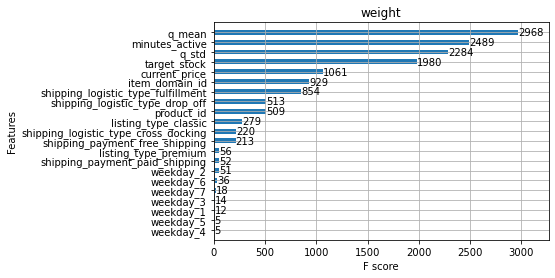

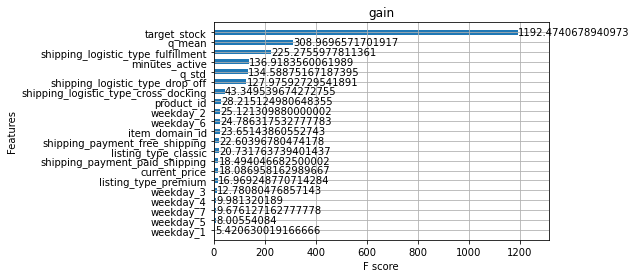

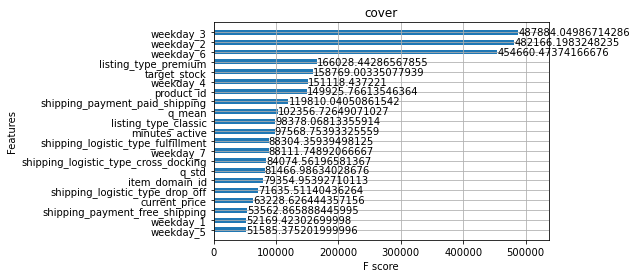

Elapsed time for model training: 4.0232924818992615 min
Training model for seed: 23 

[0]	train_sample-aft-nloglik:4.78269
[25]	train_sample-aft-nloglik:4.48421
[50]	train_sample-aft-nloglik:4.24298
[75]	train_sample-aft-nloglik:4.07112
[100]	train_sample-aft-nloglik:3.97228
[125]	train_sample-aft-nloglik:3.92961
[150]	train_sample-aft-nloglik:3.91862
[175]	train_sample-aft-nloglik:3.91637
[200]	train_sample-aft-nloglik:3.91563
[225]	train_sample-aft-nloglik:3.91526
[250]	train_sample-aft-nloglik:3.91499
[275]	train_sample-aft-nloglik:3.91478
[299]	train_sample-aft-nloglik:3.91462


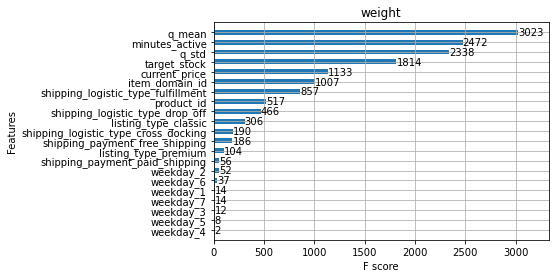

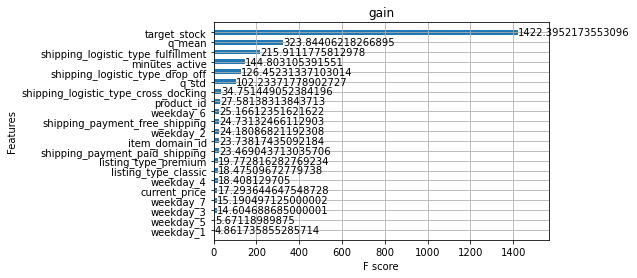

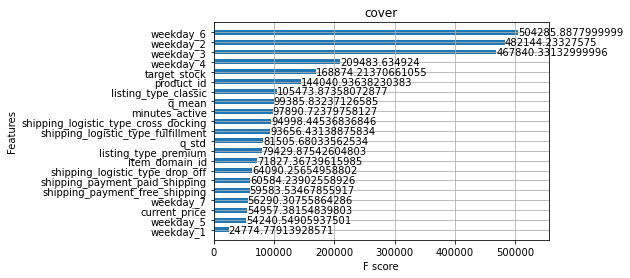

Elapsed time for model training: 3.7143330454826353 min
Training model for seed: 41 

[0]	train_sample-aft-nloglik:4.78269
[25]	train_sample-aft-nloglik:4.48421
[50]	train_sample-aft-nloglik:4.24298
[75]	train_sample-aft-nloglik:4.07125
[100]	train_sample-aft-nloglik:3.97137
[125]	train_sample-aft-nloglik:3.92961
[150]	train_sample-aft-nloglik:3.91957
[175]	train_sample-aft-nloglik:3.91646
[200]	train_sample-aft-nloglik:3.91565
[225]	train_sample-aft-nloglik:3.91526
[250]	train_sample-aft-nloglik:3.91499
[275]	train_sample-aft-nloglik:3.91479
[299]	train_sample-aft-nloglik:3.91463


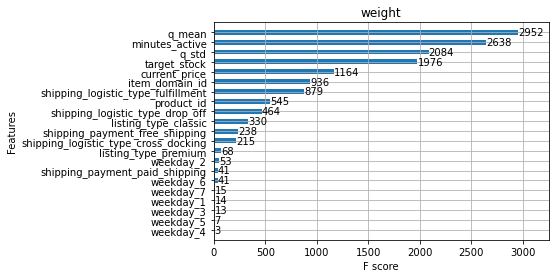

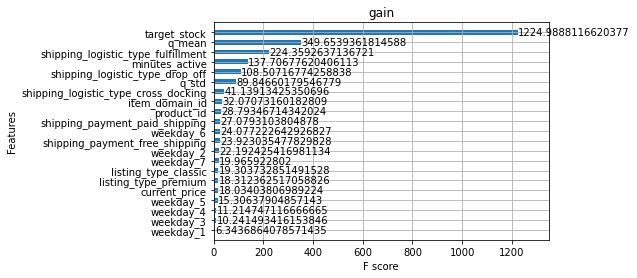

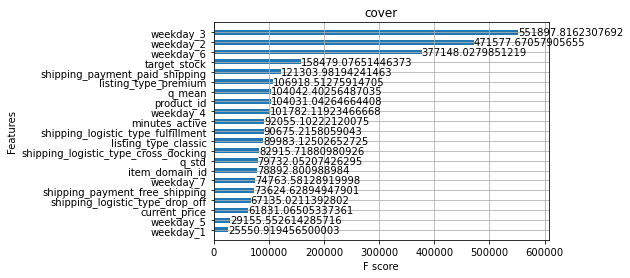

Elapsed time for model training: 3.474522582689921 min


In [32]:
sites = ["MLA","MLB","MLM"]
models_by_site = {"MLA":list(), "MLB":list(), "MLM":list(),}
iters_by_site = {"MLA":250, "MLB":300, "MLM":300, }

SEED_LIST = [2, 11, 19, 23, 41]

for site in sites:
    print("-"*90)
    print(f"Training model for site: {site}")
    
    train_dset = (
        dataset
        .query("site_id == @site")
        .reset_index(drop=True)
    )
        
    # train data matrix
    dtrain = xgb.DMatrix(data = train_dset.loc[:, numeric_cols+categs_cols], )
    dtrain.set_float_info('label_lower_bound', train_dset.id_lower.values)
    dtrain.set_float_info('label_upper_bound', train_dset.id_upper.values)

    # sample of train data matrix for metric tracking
    sample_index = train_dset.sample(frac=0.33).index
    dtrain_sample = xgb.DMatrix(data = train_dset.loc[sample_index, numeric_cols+categs_cols], )
    dtrain_sample.set_float_info('label_lower_bound', train_dset.loc[sample_index].id_lower.values)
    dtrain_sample.set_float_info('label_upper_bound', train_dset.loc[sample_index].id_upper.values)
    
    for seed in SEED_LIST:
        print(f"Training model for seed: {seed} \n")
        tic = time.time()
        
        _model_params = dict(model_params)
        _model_params["seed"] = seed
        
        model = xgb.train(
            params = _model_params,
            dtrain = dtrain,
            num_boost_round = iters_by_site[site],
            early_stopping_rounds = iters_by_site[site]+1,
            evals = [(dtrain_sample,"train_sample")],
            verbose_eval = 25,
        )

        xgb.plot_importance(model, height=0.5, importance_type="weight", title="weight")
        xgb.plot_importance(model, height=0.5, importance_type="gain", title="gain")
        xgb.plot_importance(model, height=0.5, importance_type="cover", title="cover")
        plt.show()

        models_by_site[site].append(model)
        tac = time.time()
        print(f"Elapsed time for model training: {(tac-tic)/60.} min")

In [92]:
preds_by_site = {"MLA":list(), "MLB":list(), "MLM":list(), }
pred_dfs = list()

for site in sites:
    dtest = xgb.DMatrix(data = test.query("site_id == @site").loc[:, numeric_cols+categs_cols])
    for model in models_by_site[site]:
        preds_by_site[site].append(model.predict(dtest))
        
    df = pd.DataFrame({
        "sku":test.query("site_id == @site").sku.values, 
        "days_to_stockout":np.mean(preds_by_site[site], axis=0),
    })
    pred_dfs.append(df)
    
preds = pd.concat(pred_dfs, ignore_index=True)

In [93]:
# calculated preds mean absolute deviation

mad_list = list()
for i in range(5):
    for j in range(5):
        if i==j: continue
        mad = np.mean(np.abs(preds_by_site["MLA"][i] - preds_by_site["MLA"][j]))
        mad_list.append(mad)
print(f"MLA - mad_mean: {np.mean(mad_list):0.4f} - {np.std(mad_list):0.4f}")

mad_list = list()
for i in range(5):
    for j in range(5):
        if i==j: continue
        mad = np.mean(np.abs(preds_by_site["MLB"][i] - preds_by_site["MLB"][j]))
        mad_list.append(mad)
print(f"MLB - mad_mean: {np.mean(mad_list):0.4f} - {np.std(mad_list):0.4f}")

mad_list = list()
for i in range(5):
    for j in range(5):
        if i==j: continue
        mad = np.mean(np.abs(preds_by_site["MLM"][i] - preds_by_site["MLM"][j]))
        mad_list.append(mad)
print(f"MLM - mad_mean: {np.mean(mad_list):0.4f} - {np.std(mad_list):0.4f}")

MLA - mad_mean: 0.2677 - 0.0082
MLB - mad_mean: 0.2211 - 0.0075
MLM - mad_mean: 0.2186 - 0.0092


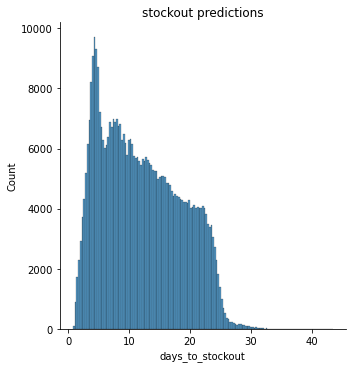

In [95]:
sns.displot(preds.days_to_stockout)
plt.title("stockout predictions")
plt.show()

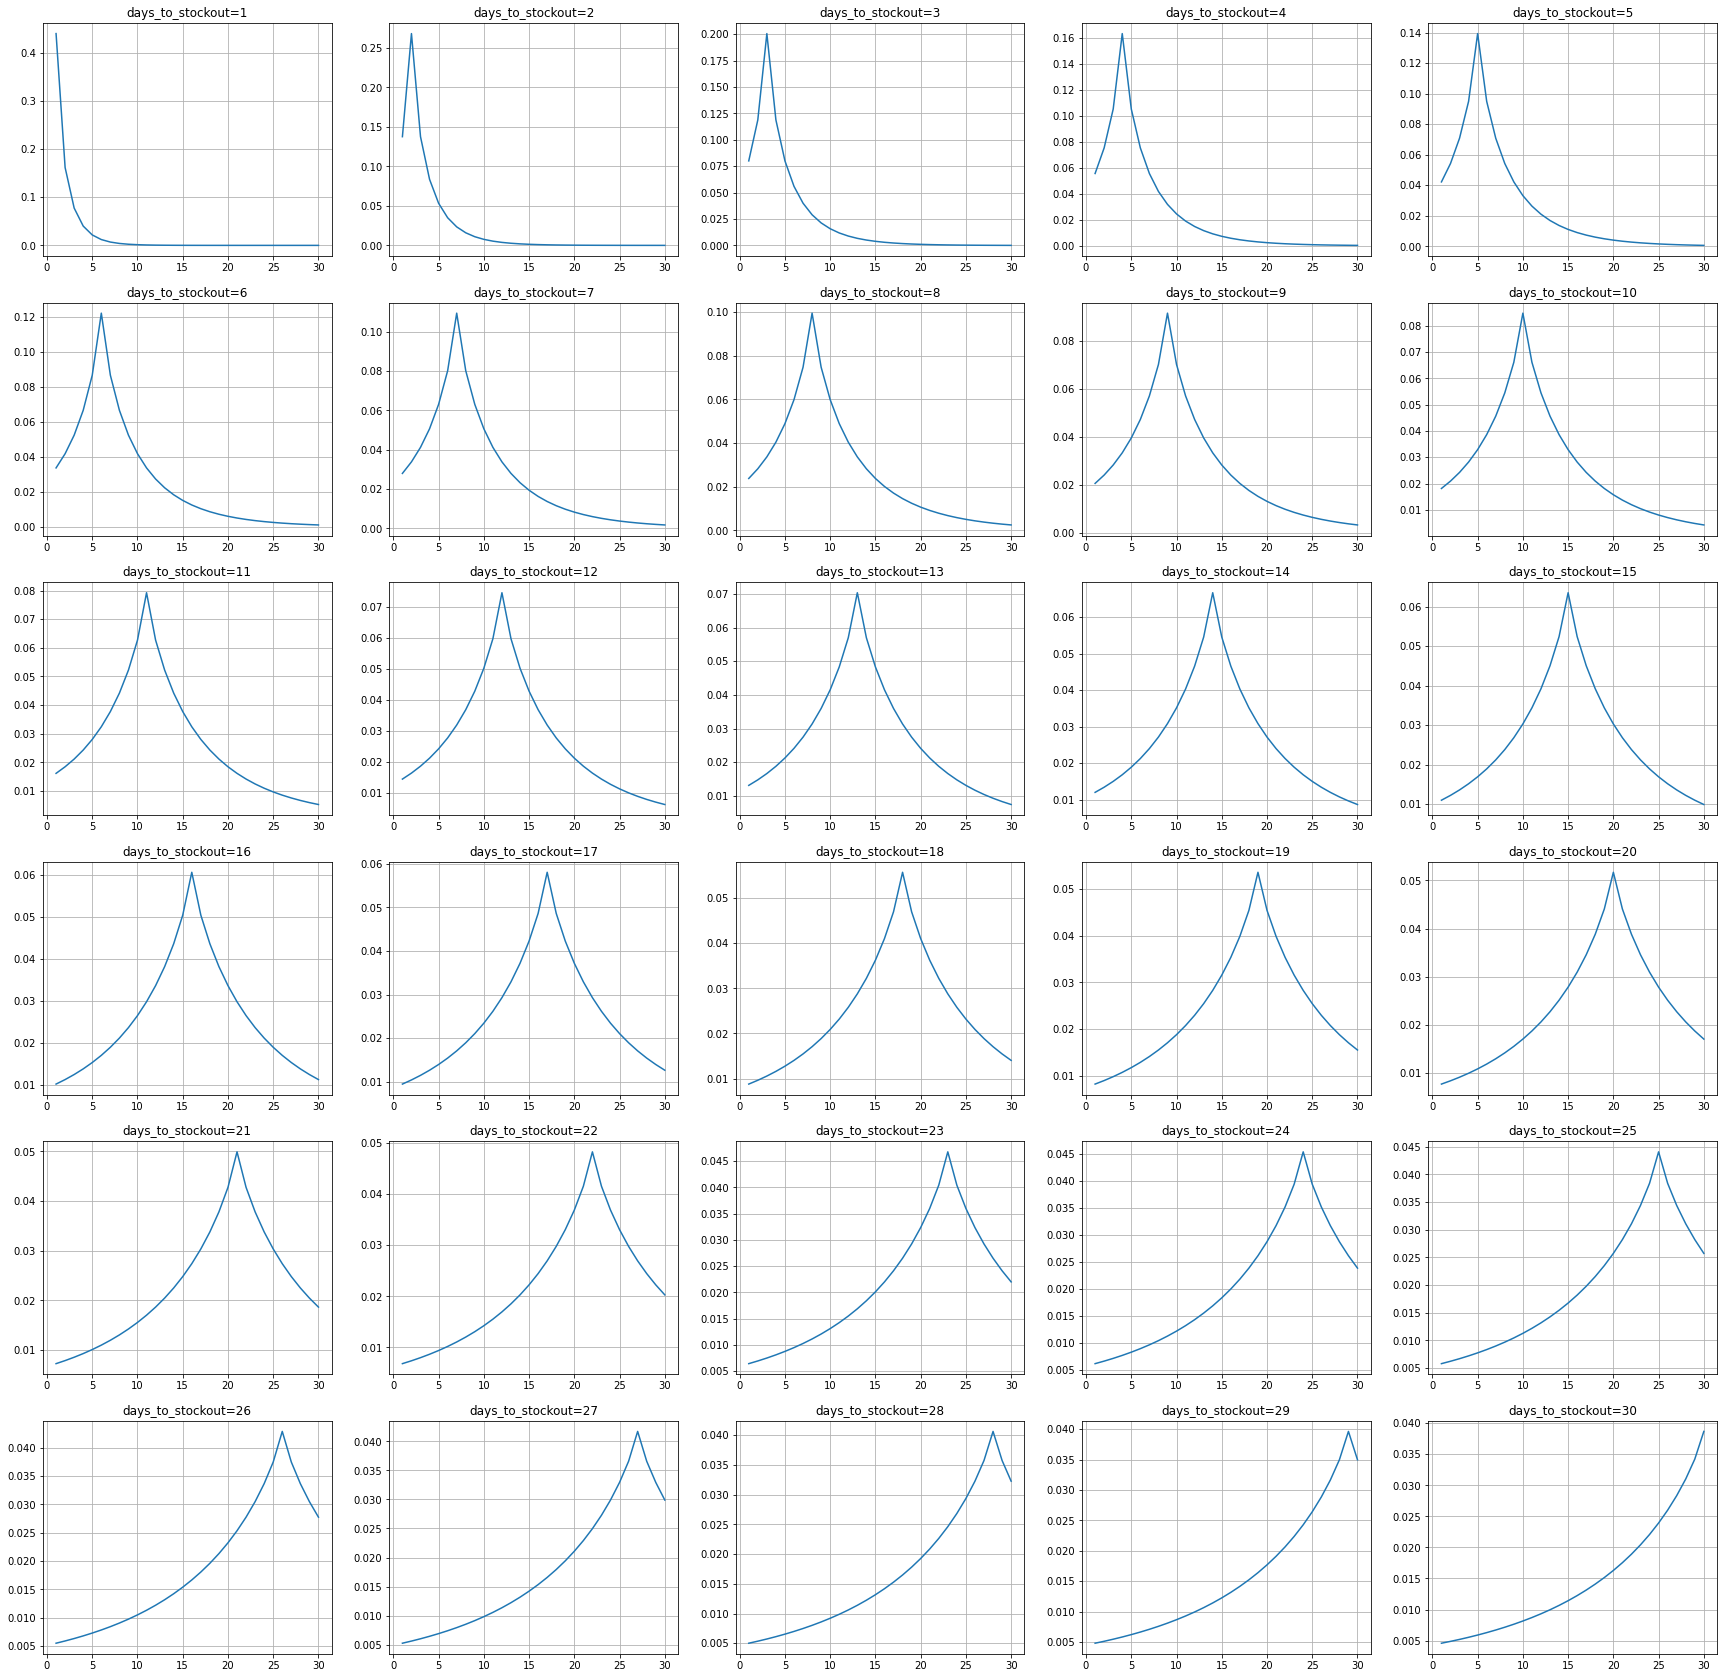

In [98]:
dist_config = {
    "lambda1": 0.794214,
    "lambda2": 0.019486,
    "lambda3": 0.998640,	
    "lambda4": 0.727768,
}

plt.figure(figsize=(30,30))
for days_to_stockout in range(1,31):
    days = np.arange(1,31)
    beta = (dist_config["lambda1"]* (days_to_stockout**dist_config["lambda2"])) 
    scale = dist_config["lambda3"]*(days_to_stockout**dist_config["lambda4"])
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=beta)
    
    plt.subplot(6,5,days_to_stockout)
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
plt.show()

In [131]:
class InventoryDaysPredictor():

    def __init__(self, oof):
        self.oof = oof.set_index("sku").copy(deep=True)

    def predict_proba(self, sku, lambda1, lambda2, lambda3, lambda4):
        days_to_stockout = self.oof.loc[sku]["pred"]

        days = np.arange(1,31)
        beta = (lambda1* (days_to_stockout**lambda2)) 
        scale = lambda3*(days_to_stockout**lambda4)
        
        probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=beta)
        #if prob is zero, replace with uniform
        if np.sum(probs) == 0: return np.ones(30) / 30
        
        return probs/np.sum(probs)

In [105]:
preds.rename({"days_to_stockout":"pred"}, axis=1, inplace=True)
predictor = InventoryDaysPredictor(preds)

In [122]:
preds_proba = list()
for sku in tqdm(preds.sku.values):
    preds_proba.append(predictor.predict_proba(sku, **dist_config))
preds_proba = np.array(preds_proba)
preds_proba = pd.DataFrame(preds_proba, index=preds.sku.values)

100%|██████████| 441834/441834 [01:52<00:00, 3918.02it/s]


***
## Generate the predictions

In [152]:
base_sub = "../subs/sub04.csv.gz"

test = pd.read_csv(f"{input_path}/test_data.csv")
base = pd.read_csv(base_sub, names=np.arange(30))
base = base.set_index(test.sku.values)
base = base.drop(preds_proba.index)

In [156]:
preds_proba_mrg = pd.concat([base, preds_proba], axis=0)
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()
preds_proba_mrg

0         1         2         3         4         5         6   \
464801  0.019750  0.022609  0.025951  0.029875  0.034514  0.040044  0.046705   
645793  0.016847  0.019016  0.021505  0.024372  0.027690  0.031550  0.036069   
99516   0.039489  0.048835  0.060966  0.077124  0.099684  0.136284  0.106429   
538100  0.017495  0.019820  0.022500  0.025604  0.029214  0.033440  0.038423   
557191  0.012436  0.013696  0.015100  0.016667  0.018419  0.020384  0.022592   
...          ...       ...       ...       ...       ...       ...       ...   
129187  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
6707    0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
170355  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
246568  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
49718   0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   

              7         8         9         10        11        12        13  \
464801  0.054857  0.065083  0.078576  0.091339  0.073615  0.061415  0.051964   
645793  0.041406  0.047781  0.055527  0.065216  0.078194  0.078436  0.065384   
99516   0.081719  0.064339  0.051399  0.041481  0.033735  0.027605  0.022705   
538100  0.044356  0.051519  0.060359  0.071728  0.088943  0.072503  0.060940   
557191  0.025083  0.027901  0.031105  0.034767  0.038982  0.043879  0.049645   
...          ...       ...       ...       ...       ...       ...       ...   
129187  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
6707    0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
170355  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
246568  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
49718   0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   

              14        15        16        17        18        19        20  \
464801  0.044355  0.038101  0.032890  0.028504  0.024785  0.021614  0.018895   
645793  0.055659  0.047889  0.041495  0.036144  0.031614  0.027745  0.024419   
99516   0.018756  0.015553  0.012940  0.010798  0.009035  0.007578  0.006370   
538100  0.051983  0.044736  0.038740  0.033708  0.029442  0.025799  0.022669   
557191  0.056584  0.065320  0.073299  0.062230  0.054185  0.047670  0.042211   
...          ...       ...       ...       ...       ...       ...       ...   
129187  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
6707    0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
170355  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
246568  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
49718   0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   

              21        22        23        24        25        26        27  \
464801  0.016554  0.014533  0.012781  0.011258  0.009932  0.008774  0.007761   
645793  0.021546  0.019051  0.016878  0.014979  0.013315  0.011852  0.010565   
99516   0.005366  0.004529  0.003829  0.003243  0.002750  0.002336  0.001987   
538100  0.019966  0.017622  0.015583  0.013803  0.012245  0.010879  0.009677   
557191  0.037552  0.033528  0.030023  0.026951  0.024244  0.021850  0.019724   
...          ...       ...       ...       ...       ...       ...       ...   
129187  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
6707    0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
170355  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
246568  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
49718   0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   

              28        29  
464801  0.006873  0.006094  
645793  0.009428  0.008424  
99516   0.001692  0.001443  
538100  0.008619  0.007685  
557191  0.017831  0.01614

In [161]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-3)
assert preds_proba_mrg.max(axis=1).max() < 1

In [162]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***